# CRISP DM


# Problem Understanding:
A central step in the ORCA pipeline is the automated mapping of natural language threat
descriptions to structured attack patterns from the Common Attack Pattern Enumeration
and Classification (CAPEC) framework. This process—referred to as Threat-to-CAPEC
Mapping—aims to translate unstructured textual threat inputs into standardized, machine-
readable representations that describe how an attacker might exploit a given vulnerability.
This mapping is critical for enabling further steps in the security analysis process, such
as correlating threats with known vulnerabilities (CWEs, CVEs), assessing risk using
scoring systems like CVSS, and informing mitigation strategies. However, the task poses
several inherent challenges:
Ambiguity: Threat descriptions are often informal, incomplete, or context-dependent.
Terminology mismatch: Natural language inputs may not directly align with the technical
vocabulary used in CAPEC definitions.
Granularity: A single threat may correspond to multiple CAPECs at varying levels of
abstraction, requiring semantic reasoning to determine relevance.
Solving this problem involves designing a system capable of understanding the semantics
of threat descriptions and reliably identifying the most appropriate CAPEC entries. This
step must balance accuracy, scalability, and interpretability to support reliable, automated
security assessments within the broader ORCA framework.

# Data Understanding

In [1]:
# imports
import pandas as pd
import json
import re
import time
from datetime import datetime, timedelta
import csv
import ollama
from IPython.display import HTML, display
from git import Repo, InvalidGitRepositoryError
import os
import shutil

from stix2 import FileSystemSource
from stix2 import Filter

from sentence_transformers import SentenceTransformer, util
import torch
import chromadb
from chromadb import Documents, EmbeddingFunction, Embeddings

import pprint
from pprint import pprint

from tqdm import tqdm
from google import genai
from google.genai import types

from pprint import pprint

from IPython.display import HTML, Markdown, display

display(HTML('''
<style>
/* White background for output area */
.output_area {
    background: white !important;
    color: black !important;
}

/* Optional: White background for DataFrame cells */
.dataframe {
    background-color: white !important;
    color: black !important;
}
</style>
'''))



c:\Users\domep\Development\Masterarbeit\MasterThesis_LLM_optimization_ORCA\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# setting display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

Import threat data from json file

In [25]:
# Load threat data from JSON file into a DataFrame
df_threats = pd.read_json('threat_data/all_threats.json')

In [26]:
# Display DataFrame information
df_threats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182 entries, 0 to 181
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Threat ID            182 non-null    object
 1   Threat title         182 non-null    object
 2   Threat Description   182 non-null    object
 3   Threat type          82 non-null     object
 4   Impact type          82 non-null     object
 5   Threat agent         182 non-null    object
 6   Vulnerability        182 non-null    object
 7   Threatened Asset     182 non-null    object
 8   Affected Components  182 non-null    object
dtypes: object(9)
memory usage: 12.9+ KB


There a 182 threats in 9 columns, each threat has a unique ID, a title, a description, a threat type, an impact type, a threat agent, one or more vulnerabilities (safed in a list), a threatened asset and a affected component

In [27]:
df_threats.describe()

,Threat ID,Threat title,Threat Description,Threat type,Impact type,Threat agent,Vulnerability,Threatened Asset,Affected Components
count,182,182,182,82,82,182,182,182,182
unique,182,181,182,16,17,2,116,58,55
top,T-O-RAN-01,External attacker exploits authentication weakness on SMO,"Unauthenticated/unauthorized access to O-RAN components could possibly be achieved via the different O-RAN interfaces, depending upon the design of the hardware-software O-RAN system and how different functions are segregated within the O-RAN system. \nO-RAN components might be vulnerable if: \n• Outdated component from the lack of update or patch management,\n• Poorly design architecture,\n• Missing appropriate security hardening,\n• Unnecessary or insecure function/protocol/component.\nAn attacker could, in such case, either inject malwares and/or manipulate existing software, harm the O-RAN components, create a performance issue by manipulation of parameters, or reconfigure the O-RAN components and disable the security features with the purpose of eavesdropping or wiretapping on various CUS & M planes, reaching northbound systems, attack broader network to cause denial-of-service, steal unprotected private keys, certificates, hash values, or other type of breaches.\nIn addition, O-RAN components could be software providing network functions, so they are likely to be vulnerable to software flaws: it could be possible to bypass firewall restrictions or to take advantage of a buffer overflow to execute arbitrary commands, etc.",Spoofing,Authenticity,All,[weak mutual authentication],"ASSET-D-12, ASSET-D-13, ASSET-D-14, ASSET-D-15, ASSET-D-16, ASSET-D-17, ASSET-D-18, ASSET-D-19, ASSET-D-20, ASSET-D-29, ASSET-D-31, ASSET-D-32",All
freq,1,2,1,28,26,178,12,24,19


In [28]:
df_threats.isnull().sum()

Threat ID                0
Threat title             0
Threat Description       0
Threat type            100
Impact type            100
Threat agent             0
Vulnerability            0
Threatened Asset         0
Affected Components      0
dtype: int64

In [29]:
df_threats.columns

Index(['Threat ID', 'Threat title', 'Threat Description', 'Threat type',
       'Impact type', 'Threat agent', 'Vulnerability', 'Threatened Asset',
       'Affected Components'],
      dtype='object')

In [30]:
df_threats.groupby('Threat type').size().reset_index(name='count').sort_values(by='count', ascending=False).reset_index(drop=True)

,Threat type,count
0,Spoofing,28
1,Denial of Service,11
2,Elevation of Privilege,10
3,Information Disclosure,9
4,Tampering,8
5,Information disclosure,4
6,Tampering; Denial of Service,2
7,"Elevation of Privilege, Information Disclosure",2
8,Elevation of Privilege; Denial of Service,1
9,"Denial of Service, Escalation of Privilege",1


In [31]:
(df_threats['Threat type'].isnull() == df_threats['Impact type'].isnull()).all()


np.True_

In [32]:
df_threats['Threat type'].value_counts(dropna=False)

Threat type
None                                                          52
NaN                                                           48
Spoofing                                                      28
Denial of Service                                             11
Elevation of Privilege                                        10
Information Disclosure                                         9
Tampering                                                      8
Information disclosure                                         4
Elevation of Privilege, Information Disclosure                 2
Tampering; Denial of Service                                   2
Information disclosure, Tampering                              1
Tampering, Information Disclosure, Escalation of Privilege     1
Denial of Service, Escalation of Privilege                     1
Denial of Service; Tampering                                   1
Elevation of Privilege; Denial of Service                      1
Tampering; El

In [33]:
df_threats['Impact type'].value_counts(dropna=False)

Impact type
None                                         52
NaN                                          48
Authenticity                                 26
Confidentiality                              14
Availability                                 12
Authorization                                 9
Integrity                                     7
Authentication                                2
Integrity; Availability                       2
Authorization. Confidentiality                1
Integrity, Confidentiality, Authorization     1
Availability; Integrity                       1
Confidentiality, Integrity                    1
Authorization; Availability                   1
Integrity; Authorization; Availability        1
Integrity, Availability                       1
Availability, Confidentiality                 1
Confidentiality, Availability                 1
Authorization, Availability                   1
Name: count, dtype: int64

In [34]:
df_threats['Vulnerability'].value_counts(dropna=False)

Vulnerability
[weak mutual authentication]                                                                                                                                                                                                                                                     12
[Weak authentication can be exploited by a tenant to move laterally across the deployment.]                                                                                                                                                                                       9
[Lack of integrity verification]                                                                                                                                                                                                                                                  5
[Lack of overload protection and rate-limiting]                                                                                                               

## Distribution Analysis


In [35]:
# some threat types as well as impact types are seperated by a comma, while others are seperated by a semicolon or a point
# Replace all semicolons with commas
df_threats['Threat type'] = df_threats['Threat type'].str.replace(';', ',', regex=False)
df_threats['Threat type'] = df_threats['Threat type'].str.replace('.', ',', regex=False)
df_threats['Impact type'] = df_threats['Impact type'].str.replace(';', ',', regex=False)
df_threats['Impact type'] = df_threats['Impact type'].str.replace('.', ',', regex=False)
# in the Threatened asssets column, some values have a underscore instead of a dash
df_threats['Threatened Asset'] = df_threats['Threatened Asset'].str.replace('_', '-', regex=False)

In [36]:
# removing leading and trailing whitespace from the 'Threat type','Impact type','Threatened asset' and 'Affected components' columns
df_threats['Threat type'] = df_threats['Threat type'].apply(
    lambda x: [t.strip() for t in x.split(',')] if isinstance(x, str) else x
)
df_threats['Impact type'] = df_threats['Impact type'].apply(
    lambda x: [t.strip() for t in x.split(',')] if isinstance(x, str) else x
)
df_threats['Threatened Asset'] = df_threats['Threatened Asset'].apply(
    lambda x: [t.strip() for t in x.split(',')] if isinstance(x, str) else x
)
df_threats['Affected Components'] = df_threats['Affected Components'].apply(
    lambda x: [t.strip() for t in x.split(',')] if isinstance(x, str) else x
)
# the vulnerability column contains a list with only one string element
# this string contains multpile vulnerabilities separated by commas
# we convert the list to this one string element and then split the string by commas
df_threats['Vulnerability'] = df_threats['Vulnerability'].apply(lambda x: x[0] if isinstance(x, list) else x)
df_threats['Vulnerability'] = df_threats['Vulnerability'].apply(
    lambda x: [t.strip() for t in x.split(',')] if isinstance(x, str) else x
)

In [37]:
# the 'Threatened Asset' column contains values like 'All' or 'ASSET-D-33 to ASSET-D-38', we solve this by manually turning this into the correct list


# Example: start from your DataFrame
# df_threats = pd.read_json(...)  # or however you're loading it

# Step 1: Drop NaNs
asset_entries = df_threats['Threatened Asset'].dropna()

# Step 2: Function to expand ranges like 'ASSET-D-33 to ASSET-D-38'
def expand_range(entry):
    match = re.match(r"(ASSET-[A-Z]-)(\d+)\s+to\s+ASSET-[A-Z]-(\d+)", entry.strip())
    if match:
        prefix, start, end = match.groups()
        return [f"{prefix}{i}" for i in range(int(start), int(end) + 1)]
    return [entry.strip()]

# Step 3: Build the set of unique assets
all_assets = set()

for entry in asset_entries:
    # If entry is a list, turn it into a string
    if isinstance(entry, list):
        entry = ', '.join(entry)
    
    # Ensure it's a string before splitting
    if isinstance(entry, str):
        parts = [p.strip() for p in entry.split(',')]
        for part in parts:
            if part.lower() == 'all':
                continue  # or expand to full known asset list if desired
            elif 'to' in part:
                expanded = expand_range(part)
                all_assets.update(expanded)
            else:
                all_assets.add(part.strip())

# Step 4: Show all unique asset names sorted
all_assets = sorted(all_assets)
pprint(all_assets)




['ASSET D-11',
 'ASSET D-20',
 'ASSET D-21',
 'ASSET-C-02',
 'ASSET-C-03',
 'ASSET-C-07',
 'ASSET-C-08',
 'ASSET-C-09',
 'ASSET-C-1',
 'ASSET-C-10',
 'ASSET-C-11',
 'ASSET-C-12',
 'ASSET-C-14',
 'ASSET-C-16',
 'ASSET-C-17',
 'ASSET-C-18',
 'ASSET-C-19',
 'ASSET-C-2',
 'ASSET-C-20',
 'ASSET-C-21',
 'ASSET-C-22',
 'ASSET-C-23',
 'ASSET-C-24',
 'ASSET-C-25',
 'ASSET-C-26',
 'ASSET-C-27',
 'ASSET-C-28',
 'ASSET-C-3',
 'ASSET-C-31',
 'ASSET-C-32',
 'ASSET-C-33',
 'ASSET-C-34',
 'ASSET-C-35',
 'ASSET-C-36',
 'ASSET-C-37',
 'ASSET-C-38',
 'ASSET-C-39',
 'ASSET-C-4',
 'ASSET-C-40',
 'ASSET-C-42',
 'ASSET-C-5',
 'ASSET-C-6',
 'ASSET-C-7',
 'ASSET-C-8',
 'ASSET-C-9',
 'ASSET-D-01',
 'ASSET-D-02',
 'ASSET-D-03',
 'ASSET-D-04',
 'ASSET-D-05',
 'ASSET-D-06',
 'ASSET-D-07',
 'ASSET-D-08',
 'ASSET-D-09',
 'ASSET-D-1',
 'ASSET-D-10',
 'ASSET-D-11',
 'ASSET-D-12',
 'ASSET-D-13',
 'ASSET-D-14',
 'ASSET-D-15',
 'ASSET-D-16',
 'ASSET-D-17',
 'ASSET-D-18',
 'ASSET-D-19',
 'ASSET-D-2',
 'ASSET-D-20',
 'ASSE

In [38]:
def normalize_assets(value):
    # Convert list to string if needed
    if isinstance(value, list):
        value = ', '.join(value)
    
    if isinstance(value, str):
        value = value.strip()
        if value.lower() == 'all':
            return all_assets
        elif 'to' in value:
            return expand_range(value)
        else:
            # handle comma-separated list like 'ASSET-D-15, ASSET-C-17'
            return [v.strip() for v in value.split(',')]
    
    return value  # leave as-is if unexpected

df_threats['Threatened Asset'] = df_threats['Threatened Asset'].apply(normalize_assets)



In [39]:
df_threats['Threatened Asset'].head(20)

0     [ASSET D-11, ASSET D-20, ASSET D-21, ASSET-C-02, ASSET-C-03, ASSET-C-07, ASSET-C-08, ASSET-C-09, ASSET-C-1, ASSET-C-10, ASSET-C-11, ASSET-C-12, ASSET-C-14, ASSET-C-16, ASSET-C-17, ASSET-C-18, ASSET-C-19, ASSET-C-2, ASSET-C-20, ASSET-C-21, ASSET-C-22, ASSET-C-23, ASSET-C-24, ASSET-C-25, ASSET-C-26, ASSET-C-27, ASSET-C-28, ASSET-C-3, ASSET-C-31, ASSET-C-32, ASSET-C-33, ASSET-C-34, ASSET-C-35, ASSET-C-36, ASSET-C-37, ASSET-C-38, ASSET-C-39, ASSET-C-4, ASSET-C-40, ASSET-C-42, ASSET-C-5, ASSET-C-6, ASSET-C-7, ASSET-C-8, ASSET-C-9, ASSET-D-01, ASSET-D-02, ASSET-D-03, ASSET-D-04, ASSET-D-05, ASSET-D-06, ASSET-D-07, ASSET-D-08, ASSET-D-09, ASSET-D-1, ASSET-D-10, ASSET-D-11, ASSET-D-12, ASSET-D-13, ASSET-D-14, ASSET-D-15, ASSET-D-16, ASSET-D-17, ASSET-D-18, ASSET-D-19, ASSET-D-2, ASSET-D-20, ASSET-D-21, ASSET-D-22, ASSET-D-23, ASSET-D-24, ASSET-D-25, ASSET-D-26, ASSET-D-27, ASSET-D-28, ASSET-D-29, ASSET-D-3, ASSET-D-30, ASSET-D-31, ASSET-D-32, ASSET-D-33, ASSET-D-34, ASSET-D-35, ASSET-D-3

In [40]:
df_threats['Threat type'].explode().value_counts()
# The most common threat type is Spoofing, which occurs 28 times

Threat type
Spoofing                   28
Denial of Service          19
Elevation of Privilege     14
Information Disclosure     14
Tampering                  14
Information disclosure      5
Escalation of Privilege     2
Name: count, dtype: int64

In [41]:
df_threats['Vulnerability'].explode().str.lower().value_counts()
# The most common vulnerability is 'lack of authentication', which occurs 17 times,
# followed by 'lack of authentication' with 12 occurences.

Vulnerability
lack of authentication                                                                       17
weak mutual authentication                                                                   12
weak authentication can be exploited by a tenant to move laterally across the deployment.     9
missing or improperly configured authorization                                                6
lack of integrity verification                                                                6
                                                                                             ..
pnfs                                                                                          1
etc.                                                                                          1
operation areas                                                                               1
physical access to the open fronthaul cable network                                           1
use of pretrained public m

In [42]:
# Step 3: Explode the list so each asset appears in its own row
asset_flat = df_threats.explode('Threatened Asset')

# Step 4: Count how often each asset appears
asset_counts = asset_flat['Threatened Asset'].value_counts()
asset_counts.head(50)

Threatened Asset
ASSET-D-15    43
ASSET-C-17    41
ASSET-D-29    40
ASSET-D-18    38
ASSET-D-14    37
ASSET-C-31    35
ASSET-D-17    35
ASSET-D-16    35
ASSET-D-12    34
ASSET-D-13    34
ASSET-D-19    34
ASSET-D-20    34
ASSET-D-32    34
ASSET-D-31    33
ASSET-C-11    33
ASSET-C-18    22
ASSET-C-10    21
ASSET-C-08    19
ASSET-C-35    18
ASSET-D-01    18
ASSET-C-34    17
ASSET-C-26    17
ASSET-C-19    16
ASSET-C-16    16
ASSET-C-20    16
ASSET-C-21    16
ASSET-C-23    16
ASSET-C-09    16
ASSET-D-04    15
ASSET-D-26    15
ASSET-D-25    15
ASSET-C-37    15
ASSET-D-37    15
ASSET-D-34    15
ASSET-D-33    15
ASSET-D-36    15
ASSET-D-35    15
ASSET-D-38    15
ASSET-C-25    14
ASSET-C-36    14
ASSET-D-21    14
ASSET-D-02    14
ASSET-D-05    14
ASSET-D-27    13
ASSET-D-28    13
ASSET-D-06    13
ASSET-D-10    13
ASSET-D-22    13
ASSET-C-02    12
ASSET-D-43    12
Name: count, dtype: int64

In [43]:
df_threats['Impact type'].explode().value_counts()

Impact type
Authenticity       26
Availability       21
Confidentiality    19
Authorization      14
Integrity          14
Authentication      2
Name: count, dtype: int64

In [44]:
df_threats['Threat type'].explode().value_counts()

Threat type
Spoofing                   28
Denial of Service          19
Elevation of Privilege     14
Information Disclosure     14
Tampering                  14
Information disclosure      5
Escalation of Privilege     2
Name: count, dtype: int64

In [45]:
print(set(df_threats['Threat agent']))

{'All except Script kiddies', 'All'}


In [46]:
df_threats['Threat agent'].value_counts()

Threat agent
All                          178
All except Script kiddies      4
Name: count, dtype: int64

In [47]:
df_threats['Affected Components'].explode().value_counts() 

Affected Components
O-Cloud                  30
Non-RT RIC               29
Shared O-RU              26
Apps/VNFs/CNFs           22
All                      19
O-DU                     17
O-RU                     16
rApps                    16
Near-RT RIC              16
SMO                      14
xApps                    12
O-DU Tenant              10
SMO Framework            10
O-DU Host                 9
O-CU                      8
O2 interface              7
External interfaces       7
R1 interface              7
UE                        7
SMO Functions             6
ASSET-C-29                6
ASSET-C-30                6
O-CU Tenant               6
CUS-Plane                 5
Apps/VNFs/CNFs images     5
O-CU Host                 5
ASSET-C-08                3
A1 interface              3
E2 interface              3
M-Plane                   3
SMO Host                  3
SMO Tenant                3
xAPPs                     3
Y1 interface              2
O2                        2


In [48]:
df_threats.columns

Index(['Threat ID', 'Threat title', 'Threat Description', 'Threat type',
       'Impact type', 'Threat agent', 'Vulnerability', 'Threatened Asset',
       'Affected Components'],
      dtype='object')

## Text analysis

In [49]:
length_of_threat_descriptions = df_threats['Threat Description'].str.len()
print(length_of_threat_descriptions.describe())
print("The average character length of the threat descriptions is", length_of_threat_descriptions.mean())
# the average length og the threat descriptions is 528.2 characters

standard_deviation = length_of_threat_descriptions.std()
print("The standard deviation of the character length of the threat descriptions is", standard_deviation)

count     182.000000
mean      528.818681
std       491.740145
min        76.000000
25%       187.250000
50%       319.000000
75%       756.250000
max      2668.000000
Name: Threat Description, dtype: float64
The average character length of the threat descriptions is 528.8186813186813
The standard deviation of the character length of the threat descriptions is 491.74014505307065


In [50]:
length_of_threat_titles = df_threats['Threat title'].str.len()
print(length_of_threat_titles.describe())
print("The average character length of the threat titles is", length_of_threat_titles.mean())
print("The standard deviation of the character length of the threat titles is", length_of_threat_titles.std())

count    182.00000
mean      57.10989
std       27.82580
min       14.00000
25%       34.00000
50%       54.00000
75%       70.00000
max      148.00000
Name: Threat title, dtype: float64
The average character length of the threat titles is 57.10989010989011
The standard deviation of the character length of the threat titles is 27.825800083090165


In [51]:

print(df_threats['Threat Description'].value_counts().head(2))
print(df_threats['Threat title'].value_counts().head(2))

Threat Description
Unauthenticated/unauthorized access to O-RAN components could possibly be achieved via the different O-RAN interfaces, depending upon the design of the hardware-software O-RAN system and how different functions are segregated within the O-RAN system. \nO-RAN components might be vulnerable if: \n• Outdated component from the lack of update or patch management,\n• Poorly design architecture,\n• Missing appropriate security hardening,\n• Unnecessary or insecure function/protocol/component.\nAn attacker could, in such case, either inject malwares and/or manipulate existing software, harm the O-RAN components, create a performance issue by manipulation of parameters, or reconfigure the O-RAN components and disable the security features with the purpose of eavesdropping or wiretapping on various CUS & M planes, reaching northbound systems, attack broader network to cause denial-of-service, steal unprotected private keys, certificates, hash values, or other type of breaches

In [52]:
df_threats[df_threats['Threat title'] == 'External attacker exploits authentication weakness on SMO']


,Threat ID,Threat title,Threat Description,Threat type,Impact type,Threat agent,Vulnerability,Threatened Asset,Affected Components
42,T-SMO-01,External attacker exploits authentication weakness on SMO,"An external attacker can exploit the improper/missing authentication weakness on SMO functions. If the authentication of O-RAN subjects on A1, O1, O2, and External interfaces on SMO is not supported or not properly implemented, those interfaces without proper credentials could be exploited to gain access to the SMO.",[Spoofing],[Authenticity],All,[Missing or improperly configured authentication],"[ASSET-C-11, ASSET-C-17]","[Non-RT RIC, SMO Framework]"
43,T-SMO-02,External attacker exploits authentication weakness on SMO,"An external attacker can exploit the improper/missing authorization weakness on SMO functions. A malicious external entity on A1, O1, O2, and External interfaces without authorization or with an incorrect access token may invoke the SMO functions. The data at rest related to that function will be leaked to the attacker. In addition, an attacker can be able to perform certain actions, e.g. disclose O-RAN sensitive information or alter O-RAN components.","[Elevation of Privilege, Information Disclosure]","[Authorization, Confidentiality]",All,[Missing or improperly configured authorization],"[ASSET-C-11, ASSET-C-17]","[Non-RT RIC, SMO Framework]"


In [63]:
threat_data_after_data_understanding = df_threats.copy()

In [64]:
threat_data_after_data_understanding.to_pickle('threat_data/threats_after_data_understanding.pk1')

## Data understanding of CAPEC data

In [53]:
from git import Repo, InvalidGitRepositoryError
import os
import shutil

from stix2 import FileSystemSource
from stix2 import Filter

In [54]:
def pull_clone_gitrepo(directory, repo):
    # Check if the data direcory exists
    if not os.path.isdir(directory):
        Repo.clone_from(repo, directory)
    else:
        try:
            # Check if the data directory is actually a repositry then pull the canges
            repo = Repo(directory)
            repo.remotes.origin.pull()
        except InvalidGitRepositoryError:
            # If not then remove the folder
            shutil.rmtree(directory)
            Repo.clone_from(repo, directory)

def prepare_capecs_df():
    pull_clone_gitrepo('./data', 'https://github.com/mitre/cti')
    fs = FileSystemSource('./data/capec/2.1')
    filt = Filter('type', '=', 'attack-pattern')

    attack_patterns = fs.query([filt])

    data_array = []
    for pattern in attack_patterns:
        if not pattern.x_capec_status == "Deprecated":
            info = []
            result = [obj for obj in pattern.external_references if obj['source_name'] == "capec"]
            info.append(result[0].external_id)
            info.append(pattern.name)
            info.append(pattern.description)
            if "x_capec_domains" in pattern:
                info.append(pattern.x_capec_domains)
            else:
                info.append("not given")
            data_array.append(info)

    columns = ['CAPEC ID', 'capec_name', 'capec_description', 'capec_domain']
    df = pd.DataFrame(data_array, columns=columns)

    df['summary'] = ''
    for index, row in df.iterrows():
        if len(row['capec_domain']) > 1:
            domains_string = ". The Domains of this are: "+', '.join(row['capec_domain'])
        else:
            domains_string = ". The Domain of this is: "+row['capec_domain'][0]

        summary = 'A CAPEC with the title '+row['capec_name']+\
                    '. The description of this CAPEC is: '+row['capec_description']+\
                    domains_string
        
        df.at[index, 'summary'] = summary
    return df


In [55]:
#generate the capecs_df
#capecs_df = prepare_capecs_df()
##safe capecs data to pickle
#capecs_df.to_pickle('capec_data/capecs.pk1')

In [56]:
#load capecs data from pickle
capecs_df = pd.read_pickle('capec_data/capecs.pk1')

In [57]:
# Display general information about capecs_df
print("Shape of capecs_df:", capecs_df.shape)
print("\nColumn names:", capecs_df.columns.tolist())
print("\nMissing values per column:\n", capecs_df.isnull().sum())
print("\nData types:\n", capecs_df.dtypes)
print("\nFirst 5 rows:")
display(capecs_df.head())
print("\nSummary statistics for text length in 'capec_description':")
desc_lengths = capecs_df['capec_description'].dropna().str.len()
print(desc_lengths.describe())

Shape of capecs_df: (559, 5)

Column names: ['CAPEC ID', 'capec_name', 'capec_description', 'capec_domain', 'summary']

Missing values per column:
 CAPEC ID             0
capec_name           0
capec_description    0
capec_domain         0
summary              0
dtype: int64

Data types:
 CAPEC ID             object
capec_name           object
capec_description    object
capec_domain         object
summary              object
dtype: object

First 5 rows:


,CAPEC ID,capec_name,capec_description,capec_domain,summary
0,CAPEC-87,Forceful Browsing,"An attacker employs forceful browsing (direct URL entry) to access portions of a website that are otherwise unreachable. Usually, a front controller or similar design pattern is employed to protect access to portions of a web application. Forceful browsing enables an attacker to access information, perform privileged operations and otherwise reach sections of the web application that have been improperly protected.",[Software],"A CAPEC with the title Forceful Browsing. The description of this CAPEC is: An attacker employs forceful browsing (direct URL entry) to access portions of a website that are otherwise unreachable. Usually, a front controller or similar design pattern is employed to protect access to portions of a web application. Forceful browsing enables an attacker to access information, perform privileged operations and otherwise reach sections of the web application that have been improperly protected.. The Domain of this is: Software"
1,CAPEC-391,Bypassing Physical Locks,"An attacker uses techniques and methods to bypass physical security measures of a building or facility. Physical locks may range from traditional lock and key mechanisms, cable locks used to secure laptops or servers, locks on server cases, or other such devices. Techniques such as lock bumping, lock forcing via snap guns, or lock picking can be employed to bypass those locks and gain access to the facilities or devices they protect, although stealth, evidence of tampering, and the integrity of the lock following an attack, are considerations that may determine the method employed. Physical locks are limited by the complexity of the locking mechanism. While some locks may offer protections such as shock resistant foam to prevent bumping or lock forcing methods, many commonly employed locks offer no such countermeasures.",[Physical Security],"A CAPEC with the title Bypassing Physical Locks. The description of this CAPEC is: An attacker uses techniques and methods to bypass physical security measures of a building or facility. Physical locks may range from traditional lock and key mechanisms, cable locks used to secure laptops or servers, locks on server cases, or other such devices. Techniques such as lock bumping, lock forcing via snap guns, or lock picking can be employed to bypass those locks and gain access to the facilities or devices they protect, although stealth, evidence of tampering, and the integrity of the lock following an attack, are considerations that may determine the method employed. Physical locks are limited by the complexity of the locking mechanism. While some locks may offer protections such as shock resistant foam to prevent bumping or lock forcing methods, many commonly employed locks offer no such countermeasures.. The Domain of this is: Physical Security"
2,CAPEC-4,Using Alternative IP Address Encodings,"This attack relies on the adversary using unexpected formats for representing IP addresses. Networked applications may expect network location information in a specific format, such as fully qualified domains names (FQDNs), URL, IP address, or IP Address ranges. If the location information is not validated against a variety of different possible encodings and formats, the adversary can use an alternate format to bypass application access control.",[Software],"A CAPEC with the title Using Alternative IP Address Encodings. The description of this CAPEC is: This attack relies on the adversary using unexpected formats for representing IP addresses. Networked applications may expect network location information in a specific format, such as fully qualified domains names (FQDNs), URL, IP address, or IP Address ranges. If the location information is not validated against a variety of different possible encodings and formats, the adversary can use an alternate format to bypass application access control.. The Domain of this is: Software"
3,C


Summary statistics for text length in 'capec_description':
count     559.000000
mean      474.048301
std       224.179346
min         0.000000
25%       301.500000
50%       427.000000
75%       624.000000
max      1069.000000
Name: capec_description, dtype: float64


In [58]:
# show rows with missing values in 'capec_description'
capecs_df[capecs_df['capec_description'].isnull()]

,CAPEC ID,capec_name,capec_description,capec_domain,summary


In [59]:
capecs_df[capecs_df['capec_domain'] == 'not given']

,CAPEC ID,capec_name,capec_description,capec_domain,summary
81,CAPEC-699,Eavesdropping on a Monitor,"An Adversary can eavesdrop on the content of an external monitor through the air without modifying any cable or installing software, just capturing this signal emitted by the cable or video port, with this the attacker will be able to impact the confidentiality of the data without being detected by traditional security tools",not given,"A CAPEC with the title Eavesdropping on a Monitor. The description of this CAPEC is: An Adversary can eavesdrop on the content of an external monitor through the air without modifying any cable or installing software, just capturing this signal emitted by the cable or video port, with this the attacker will be able to impact the confidentiality of the data without being detected by traditional security tools. The Domains of this are: n, o, t, , g, i, v, e, n"


In [60]:
capecs_df['capec_domain'].value_counts()

capec_domain
[Software]                                                                     287
[Communications, Software]                                                      67
[Social Engineering]                                                            30
[Software, Hardware]                                                            28
[Physical Security]                                                             15
[Communications]                                                                13
[Software, Physical Security, Hardware]                                          9
[Software, Software, Software]                                                   9
[Supply Chain, Hardware]                                                         9
[Social Engineering, Supply Chain, Software]                                     8
[Supply Chain, Physical Security, Hardware]                                      8
[Supply Chain, Software]                                                  

In [61]:
# value counts for 'capec_domain'
capecs_df['capec_domain'].explode().value_counts(dropna=False)

capec_domain
Software              490
Communications        101
Hardware               91
Social Engineering     66
Supply Chain           52
Physical Security      39
not given               1
Name: count, dtype: int64

In [62]:
duplicates = capecs_df[capecs_df['capec_domain'].apply(lambda x: len(x) != len(set(x)))]['capec_domain']

print(f"Count of rows with duplicates: {len(duplicates)}")
print(duplicates)


Count of rows with duplicates: 30
25                         [Software, Software, Software]
29                                   [Software, Software]
54                                   [Hardware, Hardware]
80                         [Software, Software, Software]
81                                              not given
86     [Social Engineering, Social Engineering, Software]
91               [Social Engineering, Social Engineering]
99                                   [Software, Software]
119                        [Software, Software, Software]
123                                  [Hardware, Hardware]
156              [Social Engineering, Social Engineering]
165                                  [Software, Software]
177                        [Software, Software, Software]
201              [Social Engineering, Social Engineering]
225                        [Software, Software, Software]
243                        [Software, Hardware, Software]
262              [Social Engineering, 

# Data Preparation

Merging title and description to match the form of the original orca pipeline.

In [65]:
df_threats = pd.read_pickle('threat_data/threats_after_data_understanding.pk1')

In [66]:
threats_summary_context = {'Threat title': 'A Threat with the title ', 'Threat Description': ' and the description '}
def add_summary_to_df(input_df, coll_context, ):
    input_df['summary'] = ''
    for key, value in coll_context.items():
        input_df['summary'] +=  value + input_df[key]

In [67]:
add_summary_to_df(df_threats, threats_summary_context)
df_threats.loc[0, 'summary']  

'A Threat with the title An attacker exploits insecure designs or lack of adaption in O-RAN components and the description Unauthenticated/unauthorized access to O-RAN components could possibly be achieved via the different O-RAN interfaces, depending upon the design of the hardware-software O-RAN system and how different functions are segregated within the O-RAN system. \nO-RAN components might be vulnerable if: \n• Outdated component from the lack of update or patch management,\n• Poorly design architecture,\n• Missing appropriate security hardening,\n• Unnecessary or insecure function/protocol/component.\nAn attacker could, in such case, either inject malwares and/or manipulate existing software, harm the O-RAN components, create a performance issue by manipulation of parameters, or reconfigure the O-RAN components and disable the security features with the purpose of eavesdropping or wiretapping on various CUS & M planes, reaching northbound systems, attack broader network to cause

Data preparation for establishing a baseline, implementing the ORCA mapping.

1. Add the embedding to the threat and to to the capec data

In [68]:
models = SentenceTransformer('sentence-transformers/all-MiniLM-L12-v2')

def preprocess_description(description):
    # remove patterns not semantically relevant
    pattern = r"\((http|https)\S+\)|['\[\]]+"
    description = re.sub(pattern, "", description)
    return description

def gen_embedding(description):
    if isinstance(description, str):
        description1 = description
    else:
        description1 = '\n'.join(description)
    description = preprocess_description(description1)
    return models.encode(description, convert_to_numpy=True)

def add_embedd_to_df(input_df, descryption_name):
    input_df['embedding'] = input_df[descryption_name].apply(gen_embedding)

In [69]:
# add embedding to the threats dataframe
add_embedd_to_df(df_threats, 'summary')

In [9]:
#threats_with_embeddings = df_threats.copy()
#threats_with_embeddings.to_pickle('threat_data/threats_with_embeddings.pk1')
threats_with_embeddings = pd.read_pickle('threat_data/threats_with_embeddings.pk1')

In [50]:
# add embedding to the capecs dataframe
#capecs_with_embeddings_df = capecs_df.copy()
#add_embedd_to_df(capecs_with_embeddings_df, 'summary')
#capecs_with_embeddings_df.to_pickle('capec_data/capecs_with_embeddings.pk1')

In [4]:
capecs_with_embeddings_df = pd.read_pickle('capec_data/capecs_with_embeddings.pk1')

2. generate the mapping of threats to capecs

In [5]:
DOMAIN = "enterprise-attack"
def gen_mapping(th_df, ca_df):
    maping = pd.DataFrame()
    if 'summary' in th_df.columns:
        th_df.rename(columns={'summary': 'summary_th_df'}, inplace=True)
    if 'summary' in ca_df.columns:
        ca_df.rename(columns={'summary': 'summary_ca_df'}, inplace=True)

    for ca_index, row_techniques in ca_df.iterrows():
        for thr_index, row_threats in th_df.iterrows():
            cosine_similarity = util.pytorch_cos_sim(torch.from_numpy(row_techniques['embedding']),
                                                     torch.from_numpy(row_threats['embedding']))
            comb = pd.concat([row_techniques, row_threats], axis=0)
            comb = comb.to_frame().T
            comb['Similarity'] = cosine_similarity
            maping = pd.concat([maping, comb], ignore_index=True)

    maping['Domain'] = DOMAIN
    return maping

In [6]:
df_threats.columns

NameError: name 'df_threats' is not defined

In [59]:
df_threats.head(1)

,Threat ID,Threat title,Threat Description,Threat type,Impact type,Threat agent,Vulnerability,Threatened Asset,Affected Components,summary_th_df,embedding
0,T-O-RAN-01,An attacker exploits insecure designs or lack of adaption in O-RAN components,"Unauthenticated/unauthorized access to O-RAN components could possibly be achieved via the different O-RAN interfaces, depending upon the design of the hardware-software O-RAN system and how different functions are segregated within the O-RAN system. \nO-RAN components might be vulnerable if: \n• Outdated component from the lack of update or patch management,\n• Poorly design architecture,\n• Missing appropriate security hardening,\n• Unnecessary or insecure function/protocol/component.\nAn attacker could, in such case, either inject malwares and/or manipulate existing software, harm the O-RAN components, create a performance issue by manipulation of parameters, or reconfigure the O-RAN components and disable the security features with the purpose of eavesdropping or wiretapping on various CUS & M planes, reaching northbound systems, attack broader network to cause denial-of-service, steal unprotected private keys, certificates, hash values, or other type of breaches.\nIn addition, O-RAN components could be software providing network functions, so they are likely to be vulnerable to software flaws: it could be possible to bypass firewall restrictions or to take advantage of a buffer overflow to execute arbitrary commands, etc.",None,None,All,[Outdated component from the lack of update or patch management],"[ASSET D-11, ASSET D-20, ASSET D-21, ASSET-C-02, ASSET-C-03, ASSET-C-07, ASSET-C-08, ASSET-C-09, ASSET-C-1, ASSET-C-10, ASSET-C-11, ASSET-C-12, ASSET-C-14, ASSET-C-16, ASSET-C-17, ASSET-C-18, ASSET-C-19, ASSET-C-2, ASSET-C-20, ASSET-C-21, ASSET-C-22, ASSET-C-23, ASSET-C-24, ASSET-C-25, ASSET-C-26, ASSET-C-27, ASSET-C-28, ASSET-C-3, ASSET-C-31, ASSET-C-32, ASSET-C-33, ASSET-C-34, ASSET-C-35, ASSET-C-36, ASSET-C-37, ASSET-C-38, ASSET-C-39, ASSET-C-4, ASSET-C-40, ASSET-C-42, ASSET-C-5, ASSET-C-6, ASSET-C-7, ASSET-C-8, ASSET-C-9, ASSET-D-01, ASSET-D-02, ASSET-D-03, ASSET-D-04, ASSET-D-05, ASSET-D-06, ASSET-D-07, ASSET-D-08, ASSET-D-09, ASSET-D-1, ASSET-D-10, ASSET-D-11, ASSET-D-12, ASSET-D-13, ASSET-D-14, ASSET-D-15, ASSET-D-16, ASSET-D-17, ASSET-D-18, ASSET-D-19, ASSET-D-2, ASSET-D-20, ASSET-D-21, ASSET-D-22, ASSET-D-23, ASSET-D-24, ASSET-D-25, ASSET-D-26, ASSET-D-27, ASSET-D-28, ASSET-D-29, ASSET-D-3, ASSET-D-30, ASSET-D-31, ASSET-D-32, ASSET-D-33, ASSET-D-34, ASSET-D-35, ASSET-D-36, ASSET-D-37, ASSET-D-38, ASSET-D-39, ASSET-D-4, ASSET-D-41, ASSET-D-43, ASSET-D-5, ASSET-D-6, ASSET-D-7, ASSET-D-8, ASSET-D-9]",[All],"A Threat with the title An attacker exploits insecure designs or lack of adaption in O-RAN components and the description Unauthenticated/unauthorized access to O-RAN components could possibly be achieved via the different O-RAN interfaces, depending upon the design of the hardware-software O-RAN system and how different functions are segregated within the O-RAN system. \nO-RAN components might be vulnerable if: \n• Outdated component from the lack of update or patch management,\n• Poorly design architecture,\n• Missing appropriate security hardening,\n• Unnecessary or insecure function/protocol/component.\nAn attacker could, in such case, either inject malwares and/or manipulate existing software, harm the O-RAN components, create a performance issue by manipulation of parameters, or reconfigure the O-RAN components and disable the security features with the purpose of eavesdropping or wiretapping on various CUS & M planes, reaching northbound systems, attack broader network to cause denial-of-service, steal unprotected private keys, certificates, hash values, or other type of breaches.\nIn addition, O-RAN components could be software providing network functions, so they are likely to be vulnerable to software flaws: it could be possible to bypass firewall restrictions or 

In [7]:
capecs_with_embeddings_df.columns

Index(['CAPEC ID', 'capec_name', 'capec_description', 'capec_domain',
       'summary', 'embedding'],
      dtype='object')

In [10]:
capec_mapping = gen_mapping(threats_with_embeddings, capecs_with_embeddings_df)

3. format the mapping

In [11]:
COLOM_MAP = {'ID': 'Technique', 'name': 'yeet', 'Threat ID': 'Name', 'tactics': 'tactic', 'Threat title':'Description'}
MAP_ORDER_capec = ['Name', 'Domain', 'Description', 'CAPEC ID', 'Similarity', 'summary_th_df', 'summary_ca_df']
def format_map(ma, MAP_ORDER):
    ma.rename(columns=COLOM_MAP, inplace=True)
    ma = ma.loc[:, MAP_ORDER]
    return ma

In [12]:
threat2capec_mapping_df = format_map(capec_mapping, MAP_ORDER_capec)

In [ ]:
# save capec mappings to pickle
#threat2capec_mapping_df.to_pickle('mapped_data/all_t2c_mappings.pk1')

In [14]:
threat2capec_mapping_df = pd.read_pickle('mapped_data/all_t2c_mappings.pk1')

In [17]:
threat2capec_mapping_df.Similarity.describe()

count    101738.000000
mean          0.322094
std           0.076980
min           0.010134
25%           0.271916
50%           0.323729
75%           0.374085
max           0.660303
Name: Similarity, dtype: float64

In [16]:
threat2capec_mapping_df.loc[0:5]

,Name,Domain,Description,CAPEC ID,Similarity,summary_th_df,summary_ca_df
0,T-O-RAN-01,enterprise-attack,An attacker exploits insecure designs or lack of adaption in O-RAN components,CAPEC-87,0.246589,"A Threat with the title An attacker exploits insecure designs or lack of adaption in O-RAN components and the description Unauthenticated/unauthorized access to O-RAN components could possibly be achieved via the different O-RAN interfaces, depending upon the design of the hardware-software O-RAN system and how different functions are segregated within the O-RAN system. \nO-RAN components might be vulnerable if: \n• Outdated component from the lack of update or patch management,\n• Poorly design architecture,\n• Missing appropriate security hardening,\n• Unnecessary or insecure function/protocol/component.\nAn attacker could, in such case, either inject malwares and/or manipulate existing software, harm the O-RAN components, create a performance issue by manipulation of parameters, or reconfigure the O-RAN components and disable the security features with the purpose of eavesdropping or wiretapping on various CUS & M planes, reaching northbound systems, attack broader network to cause denial-of-service, steal unprotected private keys, certificates, hash values, or other type of breaches.\nIn addition, O-RAN components could be software providing network functions, so they are likely to be vulnerable to software flaws: it could be possible to bypass firewall restrictions or to take advantage of a buffer overflow to execute arbitrary commands, etc.","A CAPEC with the title Forceful Browsing. The description of this CAPEC is: An attacker employs forceful browsing (direct URL entry) to access portions of a website that are otherwise unreachable. Usually, a front controller or similar design pattern is employed to protect access to portions of a web application. Forceful browsing enables an attacker to access information, perform privileged operations and otherwise reach sections of the web application that have been improperly protected.. The Domain of this is: Software"
1,T-O-RAN-02,enterprise-attack,An attacker exploits misconfigured or poorly configured O-RAN components,CAPEC-87,0.269296,"A Threat with the title An attacker exploits misconfigured or poorly configured O-RAN components and the description Unauthenticated/unauthorized access to O-RAN components could possibly be achieved via the different O-RAN interfaces, depending upon the configuration of the hardware-software O-RAN system. \nO-RAN components might be vulnerable if: \n• Errors from the lack of configuration change management,\n• Misconfigured or poorly configured O-RAN components,\n• Improperly configured permissions,\n• Unnecessary features are enabled (e.g. unnecessary ports, services, accounts, or privileges),\n• Default accounts and their passwords still enabled and unchanged,\n• Security features are disabled or not configured securely.\nAn attacker could, in such case, either inject malwares and/or manipulate existing software, harm the O-RAN components, create a performance issue by manipulation of parameters, or reconfigure the O-RAN components and disable the security features with the purpose of eavesdropping or wiretapping on various CUS & M planes, reaching northbound systems, attack broader network to cause denial-of-service, steal unprotected private keys, certificates, hash values, or other type of breaches.","A CAPEC with the title Forceful Browsing. The description of this CAPEC is: An attacker employs forceful browsing (direct URL entry) to access portions of a website that are otherwise unreachable. Usually, a front controller or similar design pattern is employed to protect access to portions of a web application. Forceful browsing enables an attacker to access information, perform privileged operations and otherwise reach sections of the web application that have been improperly protected.. The Domain of this is: Software"
2,T-O-RAN-03,enterpr

In [69]:
# for every threat name display the first 10 capecs with the highest similarity
# --- Group by 'Name' (Threat Name) and get the top 5 for each ---
top_capec_per_threat = threat2capec_mapping_df.groupby('Name').apply(
    lambda x: x.nlargest(1, 'Similarity')
).reset_index(drop=True)

# --- Display the results ---
print("Top CAPEC for Each Threat:")
for threat_name in top_capec_per_threat['Name'].unique():
    print(f"\nThreat: {threat_name}")
    threat_top_capecs = top_capec_per_threat[top_capec_per_threat['Name'] == threat_name]
    # Select relevant columns for display
    display_cols = ['CAPEC ID', 'Similarity', 'Description'] # Assuming 'Description' is the CAPEC Description now
    for index, row in threat_top_capecs[display_cols].iterrows():
        # Shorten description for readability if it's the CAPEC description
        desc = row['Description']
        if len(desc) > 100:
            desc = desc[:97] + "..."
        print(f"  - CAPEC ID: {row['CAPEC ID']}, Similarity: {row['Similarity']:.4f}, Description: {desc}")

Top CAPEC for Each Threat:

Threat: T-A1-01
  - CAPEC ID: CAPEC-94, Similarity: 0.5257, Description: Untrusted peering between Non-RT-RIC and Near-RT-RIC

Threat: T-A1-02
  - CAPEC ID: CAPEC-387, Similarity: 0.6062, Description: Malicious function or application monitors messaging across A1 interface

Threat: T-A1-03
  - CAPEC ID: CAPEC-387, Similarity: 0.5743, Description: Malicious function or application modifies messaging across A1 interface

Threat: T-AAL-01
  - CAPEC ID: CAPEC-440, Similarity: 0.5106, Description: Attacker exploits insecure API to gain access to hardware accelerator resources

Threat: T-AAL-02
  - CAPEC ID: CAPEC-469, Similarity: 0.4672, Description: Internal Overload DoS attack targeting AAL services

Threat: T-AAL-03
  - CAPEC ID: CAPEC-663, Similarity: 0.4982, Description: Fail to clear resources

Threat: T-AAL-04
  - CAPEC ID: CAPEC-401, Similarity: 0.5316, Description: HAM compromise

Threat: T-AAL-05
  - CAPEC ID: CAPEC-456, Similarity: 0.5835, Description:

/tmp/ipykernel_19687/52619477.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_capec_per_threat = threat2capec_mapping_df.groupby('Name').apply(


In [70]:
top_capec_per_threat['Similarity'].describe()

count    182.000000
mean       0.522769
std        0.053539
min        0.394582
25%        0.485878
50%        0.519037
75%        0.551577
max        0.660303
Name: Similarity, dtype: float64

In [72]:
threat2capec_mapping_df['Similarity'].describe()

count    101738.000000
mean          0.322094
std           0.076980
min           0.010134
25%           0.271916
50%           0.323729
75%           0.374085
max           0.660303
Name: Similarity, dtype: float64

In [73]:
# threat with the highest similarity to a capec
highest_similarity = threat2capec_mapping_df['Similarity'].max()
highest_similarity_row = threat2capec_mapping_df[threat2capec_mapping_df['Similarity'] == highest_similarity]
print("Threat with the highest similarity to a CAPEC:")
print(highest_similarity_row[['Name', 'CAPEC ID', 'Similarity', 'Description']])    

Threat with the highest similarity to a CAPEC:
               Name   CAPEC ID  Similarity  \
79883  T-OPENSRC-01  CAPEC-538    0.660303   

                                                                                                                                          Description  
79883  Developers use SW components with known vulnerabilities and untrusted libraries that can be exploited by an attacker through a backdoor attack  


In [74]:
# lowest similarity threat to a capec
lowest_similarity = threat2capec_mapping_df['Similarity'].min()
lowest_similarity_row = threat2capec_mapping_df[threat2capec_mapping_df['Similarity'] == lowest_similarity]
print("Threat with the lowest similarity to a CAPEC:")
print(lowest_similarity_row[['Name', 'CAPEC ID', 'Similarity', 'Description']])

Threat with the lowest similarity to a CAPEC:
           Name   CAPEC ID  Similarity  \
68773  T-AAL-02  CAPEC-394    0.010134   

                                               Description  
68773  Internal Overload DoS attack targeting AAL services  


In [75]:
# average similarity overall
average_similarity = threat2capec_mapping_df['Similarity'].mean()
print("Average similarity:", average_similarity)

Average similarity: 0.32209402


4. Safe the mappings above 0.55 similarity to a csv file

In [23]:
CAPEC_CSV_FILENAME = 'general_threats_capec_mapping'
similarity = 0.55
def filter_threshold_hfc(df, filter_criteria, min_similarity):
    filtered_df = df[df['Similarity'] > min_similarity]
    filtered_df = filtered_df.reset_index(drop=True)
    return filtered_df

In [24]:

capec_mapping_hfc = filter_threshold_hfc(threat2capec_mapping_df, "Name",similarity)
capec_mapping_hfc.to_csv("./mapped_data/hfc_"+CAPEC_CSV_FILENAME+"_min"+str(similarity)+".csv", sep=';', index=False)

5. Compare ORCA mappings to our mappings

In [30]:
orca_mappings = pd.read_csv('mapped_data/ORCA_mappings_min0.55.csv', sep=';')
our_mappings = pd.read_csv('mapped_data/hfc_general_threats_capec_mapping_min0.55.csv', sep=';')
#our_mappings = capec_mapping_hfc
print(orca_mappings.columns, orca_mappings.shape)
print(our_mappings.columns, our_mappings.shape)

Index(['Name', 'Domain', 'Description', 'CAPEC ID', 'Similarity'], dtype='object') (190, 5)
Index(['Name', 'Domain', 'Description', 'CAPEC ID', 'Similarity',
       'summary_th_df', 'summary_ca_df'],
      dtype='object') (176, 7)


In [31]:
average_similarity_orca = orca_mappings['Similarity'].mean()
average_similarity_our = our_mappings['Similarity'].mean()
average_similarity_orca, average_similarity_our

(np.float64(0.577509985631579), np.float64(0.5765717128409091))

In [32]:
diff_mean = average_similarity_orca - average_similarity_our
print(f"{diff_mean:.8f}")

0.00093827


In [33]:
median_similarity_orca = orca_mappings['Similarity'].median()
median_similarity_our = our_mappings['Similarity'].median()
median_similarity_orca, median_similarity_our

(np.float64(0.570489), np.float64(0.569787415))

In [34]:
diff_med = median_similarity_orca -median_similarity_our
print(f"{diff_med:.8f}")

0.00070159


In [86]:
# Merge ORCA and our mappings on 'Name' and 'CAPEC ID'
merged_similarities = pd.merge(
    orca_mappings[['Name', 'CAPEC ID', 'Similarity']],
    our_mappings[['Name', 'CAPEC ID', 'Similarity']],
    on=['Name', 'CAPEC ID'],
    how='outer',
    suffixes=('_orca', '_our')
)

# Save to CSV
merged_similarities.to_csv('./mapped_data/merged_orca_our_similarities.csv', sep=';', index=False)

# Display the first few rows for verification
merged_similarities.head()

,Name,CAPEC ID,Similarity_orca,Similarity_our
0,T-A1-02,CAPEC-12,0.584865,0.592353
1,T-A1-02,CAPEC-387,0.596484,0.606208
2,T-A1-02,CAPEC-388,0.564509,0.577323
3,T-A1-02,CAPEC-94,0.579672,0.569238
4,T-A1-03,CAPEC-12,0.566429,0.565207


In [87]:
threats_in_orca_not_in_our = set(orca_mappings['Name']) - set(our_mappings['Name'])
print("Threats in ORCA mappings but not in our mappings:", threats_in_orca_not_in_our)
threats_in_our_not_in_orca = set(our_mappings['Name']) - set(orca_mappings['Name'])
print("Threats in our mappings but not in ORCA mappings:", threats_in_our_not_in_orca)  

Threats in ORCA mappings but not in our mappings: {'T-SharedORU-42', 'T-SMO-24', 'T-PHYS-01', 'T-SharedORU-20', 'T-AppLCM-05', 'T-CPLANE-01', 'T-VL-01', 'T-SMO-22', 'T-GEN-01'}
Threats in our mappings but not in ORCA mappings: {'T-VM-C-02', 'T-xApp-04'}


In [88]:
# Name and Capec ID combinations where one similarity is missing
missing_similarities = merged_similarities[(merged_similarities['Similarity_orca'].isnull()) | (merged_similarities['Similarity_our'].isnull())]
print("Name and Capec ID combinations where one similarity is missing:")
print(missing_similarities[['Name', 'CAPEC ID']].head(10))  # Display first 10 for brevity

Name and Capec ID combinations where one similarity is missing:
           Name   CAPEC ID
5       T-A1-03  CAPEC-272
21  T-AppLCM-01  CAPEC-387
22  T-AppLCM-01  CAPEC-441
33  T-AppLCM-02  CAPEC-441
34  T-AppLCM-02  CAPEC-480
35  T-AppLCM-02  CAPEC-502
36  T-AppLCM-02  CAPEC-669
37  T-AppLCM-05  CAPEC-445
38  T-AppLCM-05  CAPEC-502
39  T-AppLCM-05  CAPEC-698


In [89]:
# only keep the rows where both similarities are not null
merged_similarities_both_similarities_exist = merged_similarities.dropna(subset=['Similarity_orca', 'Similarity_our'])
merged_similarities_both_similarities_exist.head(5)

,Name,CAPEC ID,Similarity_orca,Similarity_our
0,T-A1-02,CAPEC-12,0.584865,0.592353
1,T-A1-02,CAPEC-387,0.596484,0.606208
2,T-A1-02,CAPEC-388,0.564509,0.577323
3,T-A1-02,CAPEC-94,0.579672,0.569238
4,T-A1-03,CAPEC-12,0.566429,0.565207


In [90]:
# difference between the two similarities
merged_similarities_both_similarities_exist['Similarity_difference'] = (merged_similarities_both_similarities_exist['Similarity_orca'] - merged_similarities_both_similarities_exist['Similarity_our']).abs()
merged_similarities_both_similarities_exist.head(5)

/tmp/ipykernel_19687/448733076.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_similarities_both_similarities_exist['Similarity_difference'] = (merged_similarities_both_similarities_exist['Similarity_orca'] - merged_similarities_both_similarities_exist['Similarity_our']).abs()


,Name,CAPEC ID,Similarity_orca,Similarity_our,Similarity_difference
0,T-A1-02,CAPEC-12,0.584865,0.592353,0.007487
1,T-A1-02,CAPEC-387,0.596484,0.606208,0.009724
2,T-A1-02,CAPEC-388,0.564509,0.577323,0.012814
3,T-A1-02,CAPEC-94,0.579672,0.569238,0.010433
4,T-A1-03,CAPEC-12,0.566429,0.565207,0.001222


In [93]:
#merged_similarities_both_similarities_exist.to_pickle('mapped_data/merged_mappings_above_055_df.pk1')

In [94]:
average_similarity_difference = merged_similarities_both_similarities_exist['Similarity_difference'].mean()
print("Average similarity difference:", average_similarity_difference)

Average similarity difference: 0.0075198472151898725


In [95]:
largest_difference_row = merged_similarities_both_similarities_exist[merged_similarities_both_similarities_exist['Similarity_difference'] == merged_similarities_both_similarities_exist['Similarity_difference'].max()]
print(largest_difference_row)    

       Name   CAPEC ID  Similarity_orca  Similarity_our  Similarity_difference
9  T-AAL-05  CAPEC-456         0.615896        0.583511               0.032385


In [96]:
smallest_difference_row = merged_similarities_both_similarities_exist[merged_similarities_both_similarities_exist['Similarity_difference'] == merged_similarities_both_similarities_exist['Similarity_difference'].min()]
print(smallest_difference_row)

            Name   CAPEC ID  Similarity_orca  Similarity_our  \
56  T-NEAR-RT-04  CAPEC-388         0.555342        0.555342   

    Similarity_difference  
56           1.000000e-07  


In [97]:
standard_deviation_difference = merged_similarities_both_similarities_exist['Similarity_difference'].std()
print("Standard deviation of similarity differences:", standard_deviation_difference)

Standard deviation of similarity differences: 0.006716251239927797


In [98]:
threats_in_orca_not_in_our = orca_mappings[~orca_mappings['Name'].isin(our_mappings['Name'])]
threats_in_orca_not_in_our

,Name,Domain,Description,CAPEC ID,Similarity
15,T-SharedORU-42,enterprise-attack,Misuse of “sudo” privileges,CAPEC-122,0.565546
27,T-SMO-22,enterprise-attack,Internal attacker floods O2 interface via SMO to cause DDoS on O-Cloud infrastructure,CAPEC-125,0.554157
28,T-SMO-24,enterprise-attack,External attacker floods O2 interface via O-Cloud to cause DDoS on SMO,CAPEC-125,0.551914
49,T-SharedORU-20,enterprise-attack,Malicious User Login Attempt to O-DU Host/Tenant,CAPEC-114,0.552419
83,T-AppLCM-05,enterprise-attack,Malicious actor modifies application’s SecurityDescriptor,CAPEC-698,0.551221
90,T-CPLANE-01,enterprise-attack,Spoofing of DL C-plane messages,CAPEC-473,0.567711
94,T-GEN-01,enterprise-attack,Software flaw attack,CAPEC-480,0.562108
97,T-VL-01,enterprise-attack,VM/Container hyperjacking attack,CAPEC-480,0.558357
101,T-PHYS-01,enterprise-attack,An intruder into a site gains physical access to O-RAN components to cause damage or access sensitive data,CAPEC-401,0.551274
141,T-AppLCM-05,enterprise-attack,Malicious actor modifies application’s SecurityDescriptor,CAPEC-502,0.579609


In [99]:
threats_in_our_not_in_orca = our_mappings[~our_mappings['Name'].isin(orca_mappings['Name'])]
threats_in_our_not_in_orca

,Name,Domain,Description,CAPEC ID,Similarity,summary_th_df,summary_ca_df
59,T-VM-C-02,enterprise-attack,VM/Container escape attack,CAPEC-480,0.550919,"A Threat with the title VM/Container escape attack and the description VNF/CNF deployed on the same physical machine as tenants share the same host kernel and host OS resources. Lack of strong isolation between the VMs/Containers and the host allows for a potential risk of a rogue VM/Container escaping the VM/Container confinement and impacting other co-hosted VMs/Containers. In others, an attacker may deploy a new malicious VM/Container configured without network rules, user limitations, etc. to bypass existing defenses within O-Cloud infrastructure.\nAttacker deploys malicious VM/Container to escapes the host (Hypervisor/Container Engine/Host OS) and reaches the server’s hardware, then the malicious VM/Container can gain root access to the whole server where it resides. This gives the malicious VM/Container full control on all the VMs/Containers hosted on the same hacked server. This could allow an attacker to undermine the confidentiality, integrity and/or availability of VNFs/CNFs resources.\nContainers can be deployed by various means, such as via Docker's create and start APIs or via a web application such as the Kubernetes dashboard or Kubeflow. Adversaries may deploy containers based on retrieved or built malicious images or from benign images that download and execute malicious payloads at runtime.\nWhen a malicious VM/Container escapes isolation, it can gain full control over the underlying host and cause any of the below serious threats:\n• Attacker would gain the ability to mount attacks on the host or compromise the host functionalities\n• Compromise the confidentiality & integrity of co-hosted VMs/Containers and tenants\n• Launch DDOS attacks on co-hosted VMs/Containers and host services thereby degrading their performance \n• Introduce new vulnerabilities in host to be used for future attacks\n• Lack of network segmentation could potentially expose other VMs/Containers in the environment to attack. An example of this could be reconnaissance, exploitation and subsequent lateral movement to another host within the cluster.","A CAPEC with the title Escaping Virtualization. The description of this CAPEC is: An adversary gains access to an application, service, or device with the privileges of an authorized or privileged user by escaping the confines of a virtualized environment. The adversary is then able to access resources or execute unauthorized code within the host environment, generally with the privileges of the user running the virtualized process. Successfully executing an attack of this type is often the first step in executing more complex attacks.. The Domain of this is: Software"
126,T-xApp-04,enterprise-attack,False or malicious A1 policies modify behavior of xApps,CAPEC-502,0.550044,"A Threat with the title False or malicious A1 policies modify behavior of xApps and the description Unauthorized access to the Non-RT RIC enables the creation of ‘false policies’ that can be issued to the Near-RT RIC for enforcement. Existing Near-RT RIC policies could also be modified to achieve a false policy. False policies passed to the Near-RT RIC would be persistent until they were modified or deleted by the Non-RT RIC or the Near-RT RIC power cycles.\nFalse policies can be created to have numerous impacts to the normal performance of the RAN. A single false A1 policy can target a specific UE, groups of UEs, or an entire cell. A false policy could influence the Near-RT RIC to configure the O-DU and O-RU functions to support Denial of Service (DoS) attacks by using feedback data to degrade RAN performance. \nFalse policies could also be used for the purpose of locating a subscriber or group of subscribers. In this case, the false policy would cause the Near-RT RIC to isolate a subscriber in the O-CU. The Near-RT RIC could also use MIMO beamforming in the O-DU and O-RU t

## Preparation for Prompt Engineering

In [ ]:
#threat_data_for_PE = df_threats[['Threat ID', 'summary_th_df']]
##save as pickle
#threat_data_for_PE.to_pickle('threat_data/threat_data_for_PE.pk1')

In [105]:
#capec_data_for_PE = capecs_df[['CAPEC ID', 'summary']]
#capec_data_for_PE.to_pickle('capec_data/capec_data_for_PE.pk1')

In [17]:
threat_data_for_PE = pd.read_pickle('threat_data/threat_data_for_PE.pk1')

In [18]:
capec_data_for_PE = pd.read_pickle('capec_data/capec_data_for_PE.pk1')

## Preparation for Retrieval Augmented Generation

In [22]:
client = chromadb.Client()

collection = client.create_collection(name="capec_summaries")

In [111]:
#capecs_for_rag = capecs_with_embeddings_df[['CAPEC ID', 'summary_ca_df', 'embedding']]
#capecs_for_rag.to_pickle('capec_data/capecs_for_rag.pk1')


In [8]:
capecs_for_rag = pd.read_pickle('capec_data/capecs_for_rag.pk1')
capecs_for_rag.columns

Index(['CAPEC ID', 'summary_ca_df', 'embedding'], dtype='object')

In [24]:
collection.add(
    documents=capecs_for_rag['summary_ca_df'].tolist(),
    embeddings=capecs_for_rag['embedding'].tolist(),
    ids=capecs_for_rag['CAPEC ID'].astype(str).tolist(),
    metadatas=capecs_for_rag[['CAPEC ID']].to_dict(orient='records')
)

In [117]:
#threat_data_for_RAG = df_threats[['Threat ID', 'summary_th_df', 'embedding' ]]
##save as pickle
#threat_data_for_RAG.to_pickle('threat_data/threat_data_for_RAG.pk1')

In [10]:
threat_data_for_RAG = pd.read_pickle('threat_data/threat_data_for_RAG.pk1')
threat_data_for_RAG.columns

Index(['Threat ID', 'summary_th_df', 'embedding'], dtype='object')

In [9]:
client = chromadb.Client()
collection = client.get_or_create_collection(name="capec_summaries")
collection.add(
documents=capecs_for_rag['summary_ca_df'].tolist(),
embeddings=capecs_for_rag['embedding'].tolist(),
ids=capecs_for_rag['CAPEC ID'].astype(str).tolist(),
metadatas=capecs_for_rag[['CAPEC ID']].to_dict(orient='records')
)
def create_rag_prompt(threat, rag_db=collection):

    # Query the collection for the threat's embedding
    query_embedding = threat['embedding'].tolist()[0]
    results = rag_db.query(
        query_embeddings=[query_embedding],
        n_results=23
    )
    retrieved_capec_ids = results['ids'][0]
    # Build the formatted string of CAPEC documents
    formatted_capec_info = ""
    for doc, meta in zip(results['documents'][0], results['metadatas'][0]):
        formatted_capec_info += f"CAPEC Information for CAPEC ID {meta['CAPEC ID']}: {doc}\n"
        formatted_capec_info += "-" * 40 + "\n" 
    return f"""
    This task involves mapping a threat summary from the
Open Radio Access Network (O-RAN) domain to relevant attack patterns.
O-RAN represents a paradigm shift in Radio Access Network (RAN)
design, moving from proprietary hardware to a more open,
virtualized, and software-driven approach. It is used for
mobile communication networks, particularly for 5G and future
generations. Key principles of O-RAN include:
- Open System: Characterized by standardized, open
interfaces to foster a multi-vendor ecosystem.
- Disaggregated RAN: Functionalities are distributed
across different physical or virtual network functions.
- Software-Driven Approach: Components are deployed on
white-box appliances and accelerators.
- Closed-Loop Control: Enabled by data-driven components
deployed on RAN Intelligent Controllers (RICs).
Now, based on the context above, analyze the following
threat summary:
{threat['summary_th_df'].values[0]}
Additionally, consider all the following candidate
CAPEC (CAPEC stands for Common Attack Pattern Enumeration and Classification) entries that were retrieved from a vector database as the {len(retrieved_capec_ids)}
most similar attack patterns to the given threat summary:
{formatted_capec_info}
From this list, identify which CAPEC IDs are most relevant
to the described threat.
As an output, provide only a JSON array containing the
selected CAPEC IDs.
Do not include any explanations or additional text,
only the JSON array.
    """

In [53]:
print(create_rag_prompt(chosen_threat, collection))


    This task involves mapping a threat summary from the
Open Radio Access Network (O-RAN) domain to relevant attack patterns.
O-RAN represents a paradigm shift in Radio Access Network (RAN)
design, moving from proprietary hardware to a more open,
virtualized, and software-driven approach. It is used for
mobile communication networks, particularly for 5G and future
generations. Key principles of O-RAN include:
- Open System: Characterized by standardized, open
interfaces to foster a multi-vendor ecosystem.
- Disaggregated RAN: Functionalities are distributed
across different physical or virtual network functions.
- Software-Driven Approach: Components are deployed on
white-box appliances and accelerators.
- Closed-Loop Control: Enabled by data-driven components
deployed on RAN Intelligent Controllers (RICs).
Now, based on the context above, analyze the following
threat summary:
A Threat with the title An attacker stands up a false base station attack by attacking an O-RU and the descr

Testing the mapping with the chromadb

In [51]:
id_for_query = 'T-ORU-01'

In [52]:
chosen_threat = threat_data_for_RAG[threat_data_for_RAG['Threat ID'] == id_for_query]
chosen_threat

,Threat ID,summary_th_df,embedding
20,T-ORU-01,"A Threat with the title An attacker stands up a false base station attack by attacking an O-RU and the description A false base station attack occurs when an attacker masquerades as a legitimate mobile network to facilitate a Man-in-The-Middle (MiTM) attack between a subscriber’s user equipment (UE) and the mobile network. \nThere are three attack scenarios on an O-RU that enable an attacker to realize a false base station attack: \n1. Hijack fronthaul to realize a false base station attack: Attacker disables an operational O-RU’s access to the open fronthaul, plugs a false base station system into the operational O-RU’s fronthaul interface, and launches a false base station attack with the O-RU providing the air interface.\n2. Recruit a standalone O-RU to realize a false base station attack: The stand-alone O-RU is an O-RU that is not operational but is available to an attacker to incorporate into a false base station system. The attacker plugs a false base station system into the standalone O-RU’s fronthaul interface and launches a false base station attack with the O-RU providing the air interface.\n3. Gain unauthorized physical access to O-RU to realize a false base station attack: An attacker gains access to external and internal components of an O-RU (other than the open fronthaul interface), connects the O-RU under attack to a false base station system, and launches a false base station attack with the O-RU providing the air interface.\nSuccessful attacks may cause:\na) For a subscriber’s UE in attack scenarios 1, 2, and 3: the false base stations, also known as SUPI/5G-GUTI catchers, retrieves a subscriber identity by forcing a UE to attach to the false base station systems. This opens the door to subscriber identity interception/disclosure and unauthorized subscriber tracking attacks. These attacks include stealing subscriber information, tampering with transmitted information, tracking subscribers, and compromising subscriber privacy.\nb) For the operator network: in attack scenario 1, the attacker removes the operational O-RU from providing service to UEs in the coverage area served by the operational O-RU.\nc) For operators and vendors in attack scenarios 1, 2, and 3, the attacker recruits legitimate operator/vendor equipment for the purpose of creating a false base station attack on subscribers, possibly harming the reputation of the operator and vendor whose O-RU was used in the attack.\nNOTE: The false base station threat has existed since GSM networks and continued to evolve and persist with the evolution of mobile networks. 5G networks are expected to introduce several security enhancements over 4G and legacy networks. Despite these security enhancements, 5G networks could still be a target of false base station attacks [19].","[-0.03495395, 0.035178028, -0.1055134, 0.010274407, 0.08200047, -0.019577578, 0.0075315195, 0.018251006, -0.032885563, 0.020352183, 0.07969532, -0.0151793435, 0.043177128, 0.00089191314, 0.07879166, 0.030495765, 0.019309783, 0.0058695795, 0.047091175, 0.022085859, -0.014857345, -0.06202555, 0.0039620334, -0.00014607058, 0.05151337, -0.10628875, 0.011307831, 0.025112031, 0.024592487, -0.020556321, 0.030067666, 0.046208147, -0.0040335446, 0.083263196, -0.04484506, -0.06627163, 0.07859292, 0.0044600093, -0.007475696, 0.01670452, 0.09404955, 0.0065918807, 0.04587974, 0.009176627, -0.032032236, -0.013557733, 0.017349208, 0.01402727, -0.060922213, -0.12536305, 0.06155578, -0.041403048, 0.011807808, 0.06615288, 0.039328348, -0.09199647, -0.012560112, 0.0813064, 0.008374526, 0.038339343, 0.02620471, 0.030698868, -0.012845542, -0.03284595, 0.017397922, -0.05241009, -0.016251963, 0.00430203, 0.029321222, 0.0697277, -0.011027186, -0.044097956, -0.10395023, -0.018087346, 0.01645306, 0.06012708, -0.14226824, 0.020983089, 0.040946644, 0.09410166, 0.037580088, -0.027501397, 0.051011812, 0.022191172, -0.018213628, 0.025539376, -0.0068234014, -0.0066775046

In [31]:
query = chosen_threat['summary_th_df'].tolist()[0]
query_embedding = chosen_threat['embedding'].tolist()[0]


In [32]:
results = collection.query(
    query_embeddings=[query_embedding],
    n_results=5,
)

In [33]:
for doc, meta in zip(results['documents'][0], results['metadatas'][0]):
    print("Text:", doc)
    print("Metadata:", meta)
    print("-" * 40)

Text: A CAPEC with the title Navigation Remapping To Propagate Malicious Content. The description of this CAPEC is: An adversary manipulates either egress or ingress data from a client within an application framework in order to change the content of messages and thereby circumvent the expected application logic.. The Domains of this are: Communications, Software
Metadata: {'CAPEC ID': 'CAPEC-387'}
----------------------------------------
Text: A CAPEC with the title Choosing Message Identifier. The description of this CAPEC is: This pattern of attack is defined by the selection of messages distributed via multicast or public information channels that are intended for another client by determining the parameter value assigned to that client. This attack allows the adversary to gain access to potentially privileged information, and to possibly perpetrate other attacks through the distribution means by impersonation. If the channel/message being manipulated is an input rather than output

In [36]:
for doc, meta in zip(results['documents'][0], results['metadatas'][0]):
    print("CAPEC Information for CAPEC ID", meta['CAPEC ID'], ":", doc)
    print("-" * 40)

CAPEC Information for CAPEC ID CAPEC-387 : A CAPEC with the title Navigation Remapping To Propagate Malicious Content. The description of this CAPEC is: An adversary manipulates either egress or ingress data from a client within an application framework in order to change the content of messages and thereby circumvent the expected application logic.. The Domains of this are: Communications, Software
----------------------------------------
CAPEC Information for CAPEC ID CAPEC-12 : A CAPEC with the title Choosing Message Identifier. The description of this CAPEC is: This pattern of attack is defined by the selection of messages distributed via multicast or public information channels that are intended for another client by determining the parameter value assigned to that client. This attack allows the adversary to gain access to potentially privileged information, and to possibly perpetrate other attacks through the distribution means by impersonation. If the channel/message being manip

In [98]:
our_mappings[our_mappings['Name'] == id_for_query]

,Name,Domain,Description,CAPEC ID,Similarity,summary_th_df,summary_ca_df
42,T-A1-02,enterprise-attack,Malicious function or application monitors messaging across A1 interface,CAPEC-94,0.569238,A Threat with the title Malicious function or application monitors messaging across A1 interface and the description Internal threat actor can gain access to the messaging across the A1 interface for a MiTM attack to read policy.,"A CAPEC with the title Adversary in the Middle (AiTM). The description of this CAPEC is: \n <xhtml:p>An adversary targets the communication between two components (typically client and server), in order to alter or obtain data from transactions. A general approach entails the adversary placing themself within the communication channel between the two components.</xhtml:p>\n . The Domains of this are: Communications, Software"
53,T-A1-02,enterprise-attack,Malicious function or application monitors messaging across A1 interface,CAPEC-387,0.606208,A Threat with the title Malicious function or application monitors messaging across A1 interface and the description Internal threat actor can gain access to the messaging across the A1 interface for a MiTM attack to read policy.,"A CAPEC with the title Navigation Remapping To Propagate Malicious Content. The description of this CAPEC is: An adversary manipulates either egress or ingress data from a client within an application framework in order to change the content of messages and thereby circumvent the expected application logic.. The Domains of this are: Communications, Software"
113,T-A1-02,enterprise-attack,Malicious function or application monitors messaging across A1 interface,CAPEC-388,0.577323,A Threat with the title Malicious function or application monitors messaging across A1 interface and the description Internal threat actor can gain access to the messaging across the A1 interface for a MiTM attack to read policy.,"A CAPEC with the title Application API Button Hijacking. The description of this CAPEC is: An attacker manipulates either egress or ingress data from a client within an application framework in order to change the destination and/or content of buttons displayed to a user within API messages. Performing this attack allows the attacker to manipulate content in such a way as to produce messages or content that looks authentic but contains buttons that point to an attacker controlled destination.. The Domains of this are: Communications, Software"
154,T-A1-02,enterprise-attack,Malicious function or application monitors messaging across A1 interface,CAPEC-12,0.592353,A Threat with the title Malicious function or application monitors messaging across A1 interface and the description Internal threat actor can gain access to the messaging across the A1 interface for a MiTM attack to read policy.,"A CAPEC with the title Choosing Message Identifier. The description of this CAPEC is: This pattern of attack is defined by the selection of messages distributed via multicast or public information channels that are intended for another client by determining the parameter value assigned to that client. This attack allows the adversary to gain access to potentially privileged information, and to possibly perpetrate other attacks through the distribution means by impersonation. If the channel/message being manipulated is an input rather than output mechanism for the system, (such as a command bus), this style of attack could be used to change the adversary's identifier to more a privileged one.. The Domain of this is: Communications"


## Preparation for Fine Tuning with LoRA

In [ ]:
#from sklearn.model_selection import train_test_split
#
## Assuming 'our_mappings' is your original pandas DataFrame
#
## 1. Split the DataFrame into 80% for training and 20% for testing
#train_df, test_df = train_test_split(
#    our_mappings,
#    test_size=0.2,      # 20% of the data will be used for the test set
#    random_state=42     # Ensures the split is the same every time you run the code
#)
#
## 2. Build the training_data list ONLY from the training portion (train_df)
#training_data = []
#for _, row in train_df.iterrows():
#    prompt = f"Threat Summary: {row['summary_th_df']}"
#    # Note: The comma at the end of the next line creates a tuple.
#    # You might want to remove it to get just the string.
#    completion = f"{row['summary_ca_df']}" # Removed trailing comma
#    capec_id = row['CAPEC ID']
#    training_data.append({"threat": prompt, "mapped_capec": completion, "capec_id": capec_id})
#
## Now 'training_data' is built from the 80% split,
## and 'test_df' holds the remaining 20% for evaluation.
#print(f"Original data size: {len(our_mappings)}")
#print(f"Training data size: {len(train_df)}")
#print(f"Test data size: {len(test_df)}")

Original data size: 163
Training data size: 130
Test data size: 33


In [6]:
# Save to JSONL format in the desired directory
output_path = "mapped_data/lora_training_data.jsonl"
with open(output_path, "w", encoding="utf-8") as f:
    for entry in training_data:
        f.write(json.dumps(entry) + "\n")

print(f"Saved {len(training_data)} training examples to '{output_path}'")

Saved 130 training examples to 'mapped_data/lora_training_data.jsonl'


In [7]:
# loading the training data from the JSONL file
output_path = "mapped_data/lora_training_data.jsonl"
with open(output_path, "r", encoding="utf-8") as f:
    training_data = [json.loads(line) for line in f]

In [125]:
training_data[0]

NameError: name 'training_data' is not defined

# Modeling

## Prompt Engineering

In [7]:
threat_data_for_PE = pd.read_pickle('threat_data/threat_data_for_PE.pk1')

In [20]:
# selecting a thest threat
df = threat_data_for_PE[threat_data_for_PE['Threat ID'] == "T-A1-02"]
df

,Threat ID,summary_th_df
82,T-A1-02,A Threat with the title Malicious function or application monitors messaging across A1 interface and the description Internal threat actor can gain access to the messaging across the A1 interface for a MiTM attack to read policy.


In [128]:
row = df.iloc[0]
row

Threat ID                                                                                                                                                                                                                                      T-A1-02
summary_th_df    A Threat with the title Malicious function or application monitors messaging across A1 interface and the description Internal threat actor can gain access to the messaging across the A1 interface for a MiTM attack to read policy.
Name: 82, dtype: object

### Small and Medium Setup code (LOCAL)

In [5]:
small_models = []

Small

In [6]:
# model options for small setup
small_models.append('deepseek-r1:1.5b')
#model = 'qwen3:1.7b'

Medium
the bigger models in the following cell, only run on the medium setup in a reasonable time
Uncomment a model and run the cell for choosing the model 

In [131]:
medium_models = []

In [133]:
# model options for medium setup
#medium_models.append('deepseek-r1:32b')
medium_models.append('deepseek-r1:8b')
#medium_models.append('deepseek-r1:70b-llama-distill-q4_K_M')

In [ ]:
# def model_inference_ollama(models, df, prompt_function):
#     model_outputs = {m: [] for m in models}

#     #format_schema = {
#     #    "type": "object",
#     #    "properties": {
#     #        "final_ids": {
#     #            "type": "array",
#     #            "items": {
#     #                "type": "string",
#     #                "pattern": "^CAPEC-[0-9]+$"
#     #            },
#     #            "minItems": 1,
#     #            "uniqueItems": True
#     #        }
#     #    },
#     #    "required": ["final_ids"]
#     #}

#     for model in models:
#         try:
#             response = ollama.generate(
#                 model=model,
#                 format=format_schema,
#                 prompt=prompt_function(df),
#                 options={'seed': 42, 'temperature': 0},
#                 think = True
#             )
#             # print(prompt_function(df))
#         except Exception as e:
#             response = f"[ERROR] {e}"
#         model_outputs[model].append(response)

#     return model_outputs


In [8]:
def model_inference_ollama(models, df, prompt_function):
    model_outputs = {m: [] for m in models}
    for model in models:
        try:
            #print(prompt_function(df))
            response = ollama.generate(
                model=model,
                prompt=prompt_function(df),
                options={'seed': 42, 'temperature': 0, 'num_ctx': 8192, 'num_predict': 3000, 'top_k': 1, 'num_keep':0 }
            )
            
        except Exception as e:
            response = f"[ERROR] {e}"
        model_outputs[model].append(response)
        print(response)
    return model_outputs


In [41]:
def display_model_results_ollama(models, model_outputs):
    for model in models:
        print("=" * 40)
        print(f"Model: {model}")

        # --- Speed & Runtime first ---
        if not model_outputs[model]:
            print("No outputs for this model.\n")
            continue
        
        resp = model_outputs[model][0]  # assumes object with eval_count and eval_duration
        tokens_per_second = resp.eval_count / (resp.eval_duration / 1e9)
        print(f"Speed: {tokens_per_second:.2f} tokens/second")

        duration_s = resp.eval_duration / 1e9
        minutes = int(duration_s // 60)
        seconds = duration_s % 60
        print(f"Total runtime: {minutes:02d} m {seconds:05.2f} seconds\n")

        # --- Then all outputs ---
        print("Output:")
        for resp in model_outputs[model]:
            cleaned_text = re.sub(
                r"<think>.*?</think>\s*", 
                "", 
                resp['response'], 
                flags=re.DOTALL
            )
            display(Markdown(cleaned_text))

Mappings of ORCA for comparison:

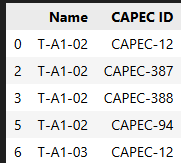

### Large Setup code (GEMINI API)

Connecting to the Google Generative AI API to try larger models
The context window is large, so it can handle the necessary amount of data

In [136]:
large_setup_models = ["gemini-2.5-pro", "gemini-2.5-flash", "gemini-2.5-flash-lite-preview-06-17"]
#models = ["gemini-2.5-flash-lite-preview-06-17"]

In [138]:
def model_inference_gemini(models, df, prompt):
    # Initialize config and client
    config = types.GenerateContentConfig(
        temperature=0.0,
        seed=42
    )
    client = genai.Client()

    model_outputs = {m: [] for m in models}
    model_stats = {m: [] for m in models}

    for idx, row in tqdm(df.iterrows(), total=len(df)):
        for model in models:
            prompt = prompt

            start_time = time.time()
            response = client.models.generate_content(
                model=model,
                contents=prompt,
                config=config
            )
            runtime = time.time() - start_time

            token_count = (
                response.usage_metadata.total_token_count +
                response.usage_metadata.prompt_token_count
            )
            tokens_per_second = token_count / runtime if runtime > 0 else 0

            model_outputs[model].append(response.text)
            model_stats[model].append({
                "runtime": runtime,
                "tokens_per_second": tokens_per_second,
                "token_count": token_count
            })

            tqdm.write(f"Inference for model {model} completed for threat {row['Threat ID']}")

    return model_outputs, model_stats

In [139]:
def display_model_result_gemini(models, model_outputs, model_stats):
    for model in models:
        print("=" * 40)
        print(f"Model: {model}")
        
        # Ensure stats exist
        stat = model_stats.get(model)
        if stat and stat["runtime"] is not None:
            print(f"Speed: {stat['tokens_per_second']:.2f} tokens/second")
            minutes = int(stat["runtime"] // 60)
            seconds = stat["runtime"] % 60
            print(f"Total runtime: {minutes:02d} m {seconds:05.2f} seconds\n")
        else:
            print("Speed: N/A\nTotal runtime: N/A\nTokens: N/A\n")

        print("Output:")
        if model in model_outputs:
            # If multiple outputs exist for this model, iterate over them
            outputs = model_outputs[model]
            if isinstance(outputs, list):
                for output in outputs:
                    cleaned_text = re.sub(r"<think>.*?</think>\s*", "", output, flags=re.DOTALL)
                    display(Markdown(cleaned_text))
            else:
                cleaned_text = re.sub(r"<think>.*?</think>\s*", "", outputs, flags=re.DOTALL)
                display(Markdown(cleaned_text))
        else:
            print("No output available.")

### Zero-Shot Prompt

In [9]:
def create_first_zero_shot_prompt(threat):
    return f"""Given the following threat summary:
    
    "{threat['summary_th_df'].values[0]}"
    
    Provide the most relevant CAPEC IDs for this threat. As an output, provide a JSON array of CAPEC IDs that are most relevant to the threat described."""

In [25]:
def create_second_zero_shot_prompt(threat):
    return f"""Given the following threat summary:
    
    "{threat['summary_th_df'].values[0]}"
    
    Provide the most relevant CAPEC IDs for this threat based on the description of each CAPEC. CAPEC stands for Common Attack Pattern Enumeration and Classification.
    
    As an output, provide a JSON array of CAPEC IDs that are most relevant to the threat described. Do not include any additional text or explanations, just the JSON array."""

In [17]:
def create_third_zero_shot_prompt(threat):
    return f"""This task involves mapping a threat summary from the Open Radio Access Network (O-RAN) domain to relevant attack patterns.

O-RAN represents a paradigm shift in Radio Access Network (RAN) design, moving from proprietary hardware to a more open, virtualized, and software-driven approach. It is used for mobile communication networks, particularly for 5G and future generations. Key principles of O-RAN include:
- Open System: Characterized by standardized, open interfaces to foster a multi-vendor ecosystem.
- Disaggregated RAN: Functionalities are distributed across different physical or virtual network functions.
- Software-Driven Approach: Components are deployed on white-box appliances and accelerators.
- Closed-Loop Control: Enabled by data-driven components deployed on RAN Intelligent Controllers (RICs).

Now, based on the context above, analyze the following threat summary:

"{threat['summary_th_df'].values[0]}"

Provide the most relevant CAPEC IDs for this threat. CAPEC stands for Common Attack Pattern Enumeration and Classification.

As an output, provide a JSON array of CAPEC IDs that are most relevant to the threat described. Do not include any additional text or explanations, just the JSON array."""

In [142]:
# Build a formatted string with all CAPEC IDs and their summaries
capec_context = ""

for _, row in capec_data_for_PE.iterrows():
    capec_id = row['CAPEC ID']
    capec_summary = row['summary']
    capec_context += f"{capec_id}: {capec_summary}\n"



In [143]:
def create_prompt_with_capec_list(threat, capec_context):
    return f"""You are a cybersecurity expert.

Here is a list of CAPEC attack pattern summaries:
{capec_context}

Given the following threat description:

"{threat['summary_th_df'].iloc[0]}"

Which 3 CAPEC ID from the list above best match the threat based on their description? Respond only with the CAPEC ID and a brief justification."""


Generating results

In [147]:
basic_zero = model_inference_ollama(small_models, df, create_basic_zero_shot_prompt)



100%|██████████| 1/1 [01:02<00:00, 62.24s/it]

Inference for model deepseek-r1:1.5b completed for threat T-A1-02
Model: deepseek-r1:1.5b
model='deepseek-r1:1.5b' created_at='2025-08-06T14:20:43.975160131Z' done=True done_reason='stop' total_duration=62101929870 load_duration=26447917001 prompt_eval_count=120 prompt_eval_duration=1359976586 eval_count=619 eval_duration=34292854634 response='<think>\nOkay, so I need to figure out which CAPEC IDs apply to this threat summary. Let me start by understanding what each part means.\n\nThe threat is about a malicious function or application monitoring messaging across the A1 interface and being able to access it for a MiTM (multi-threat) attack to read policies. So, the main elements here are:\n\n1. Malicious function or application\n2. Monitoring messaging across A1 interface\n3. Access to messaging data\n4. Potential threat through a multi-threat attack\n\nNow, CAPEC stands for Common Attack Pattern Enumeration and Classification. Each CAPEC ID has specific categories that define differen

```json
[
  "C",
  "T"
]
```

In [151]:
display_model_results_ollama(small_models, basic_zero)

Model: deepseek-r1:1.5b
Speed: 18.05 tokens/second
Total runtime: 00 m 34.29 seconds

Output:


```json
[
  "C",
  "T"
]
```

### Few-Shot Prompt

In [56]:

our_mappings = pd.read_csv('mapped_data/hfc_general_threats_capec_mapping_min0.55.csv', sep=';')

In [57]:
# sort by similarity
sorted_mappings = our_mappings.sort_values(by='Similarity', ascending=False)
sorted_mappings.head(3)

,Name,Domain,Description,CAPEC ID,Similarity,summary_th_df,summary_ca_df
149,T-OPENSRC-01,enterprise-attack,Developers use SW components with known vulnerabilities and untrusted libraries that can be exploited by an attacker through a backdoor attack,CAPEC-538,0.660303,"A Threat with the title Developers use SW components with known vulnerabilities and untrusted libraries that can be exploited by an attacker through a backdoor attack and the description The O-RAN Software Community is a Linux Foundation project, supported and funded by O-RAN to lead the implementation of the O-RAN specifications in Open Source. Industry has recognized that Open Source code introduces security risks. Open Source vulnerabilities are publicly available on the National Vulnerability Database (NVD). While this is intended for developers to disclose vulnerabilities, it is also used by hackers to exploit those vulnerabilities. Vulnerabilities frequently propagate as developers re-use free open source code enabling backdoors to attacks. There have been notable vulnerabilities from downloading open source libraries and dependencies, as well as supply chain risks when downloading Open Source code from untrusted repositories.\nSome O-RAN vendors and operators may not have accurate inventories of open-source software dependencies used by their different applications, or a process to receive and manage notifications concerning discovered vulnerabilities or available patches from the community supporting the open-source.\nSome O-RAN vendors may not have a lack of consistent Supply Chain traceability and security, and a lack of coding best practices conflicts with Security-by-Design principles.\nDevelopers may use modules with known vulnerabilities and untrusted libraries that can be exploited by an attacker through a backdoor attack.\nAttackers can exploit a vulnerability on the open source code and infects a hypervisor, operating system, VM or container with a malware.","A CAPEC with the title Open-Source Library Manipulation. The description of this CAPEC is: Adversaries implant malicious code in open source software (OSS) libraries to have it widely distributed, as OSS is commonly downloaded by developers and other users to incorporate into software development projects. The adversary can have a particular system in mind to target, or the implantation can be the first stage of follow-on attacks on many systems.. The Domain of this is: Software"
132,T-O-RAN-07,enterprise-attack,An attacker compromises O-RAN monitoring mechanisms and log files integrity and availability,CAPEC-268,0.658977,"A Threat with the title An attacker compromises O-RAN monitoring mechanisms and log files integrity and availability and the description Improper / missing controls for protection of security event log files generated by O-RAN components and the lack of security events logged together with a unique system reference (e.g. host name, IP or MAC address) and the exact time the incident occurred do not allow a correct and rapid audit in case of security incident occurrence. Security restoration is delayed. Compromise of availability and integrity of security event log files could conduct to delays, wrong audit results, delays in security restoration, threats persistence.","A CAPEC with the title Audit Log Manipulation. The description of this CAPEC is: The attacker injects, manipulates, deletes, or forges malicious log entries into the log file, in an attempt to mislead an audit of the log file or cover tracks of an attack. Due to either insufficient access controls of the log files or the logging mechanism, the attacker is able to perform such actions.. The Domain of this is: Software"
14,T-RADIO-01,enterprise-attack,"Disruption through radio jamming, sniffing and spoofing",CAPEC-605,0.652461,"A Threat with the title Disruption through radio jamming, sniffing and spoofing and the description Like for any wireless technology, disruption through radio jamming is possible by an

In [58]:
first_few_shot_example = sorted_mappings.iloc[0]
second_few_shot_example = sorted_mappings.iloc[1]
third_few_shot_example = sorted_mappings.iloc[2]

In [66]:
few_shot_examples = first_few_shot_example.to_dict(), second_few_shot_example.to_dict(), third_few_shot_example.to_dict()
few_shot_examples = pd.DataFrame(few_shot_examples)
few_shot_examples.to_pickle("mapped_data/few_shot_examples.pkl")

In [11]:

few_shot_examples = pd.read_pickle("mapped_data/few_shot_examples.pkl")
def create_few_shot_prompt(threat):
    # Build the instruction part
    base_prompt = f"""This task involves mapping a threat summary from the Open Radio Access Network (O-RAN) domain to relevant attack patterns. O-RAN represents a paradigm shift in Radio Access Network (RAN) design, moving from proprietary hardware to a more open, virtualized, and software-driven approach. It is used for mobile communication networks, particularly for 5G and future generations. Key principles of O-RAN include:
- Open System: Characterized by standardized, open interfaces to foster a multi-vendor ecosystem.
- Disaggregated RAN: Functionalities are distributed across different physical or virtual network functions.
- Software-Driven Approach: Components are deployed on white-box appliances and accelerators.
- Closed-Loop Control: Enabled by data-driven components deployed on RAN Intelligent Controllers (RICs).

Now, based on the context above, analyze the following threat summary: "{threat['summary_th_df'].values[0]}"
Provide the most relevant CAPEC IDs for this threat. CAPEC stands for Common Attack Pattern Enumeration and Classification.

As an output, provide a JSON array of CAPEC IDs that are most relevant to the threat described. This can be none, one or multiple IDs.
Do not include any additional text or explanations, just the JSON array.

Here are some examples:
"""

    # Few-shot examples
    examples = []
    ids = []
    for example in few_shot_examples.to_dict(orient='records'):
        ids.append(example['CAPEC ID'])
        example_text = f"""
Example:
Threat Name: {example['Name']}
Threat Summary: {example['summary_th_df']}
CAPEC Summary: {example['summary_ca_df']}
Mapped CAPEC ID: {example['CAPEC ID']}
If the CAPEC is relevant to the threat, the output should include:
"{example['CAPEC ID']}"
"""
        examples.append(example_text.strip())
    
    #collected_ids_formatted = 'After evaluating the CAPECs fit to the threat based on their summaries, the final json output with the CAPEC IDs that fit looks like: [' + ",".join([f'"{i}"' for i in ids]) + ']'
    # Combine everything
    full_prompt = base_prompt + "\n\n".join(examples) + "\n\n"# + collected_ids_formatted
    return full_prompt


In [74]:
pprint(create_few_shot_prompt(threat_data_for_PE['summary_th_df'].iloc[0]))

('This task involves mapping a threat summary from the Open Radio Access '
 'Network (O-RAN) domain to relevant attack patterns. O-RAN represents a '
 'paradigm shift in Radio Access Network (RAN) design, moving from proprietary '
 'hardware to a more open, virtualized, and software-driven approach. It is '
 'used for mobile communication networks, particularly for 5G and future '
 'generations. Key principles of O-RAN include:\n'
 '- Open System: Characterized by standardized, open interfaces to foster a '
 'multi-vendor ecosystem.\n'
 '- Disaggregated RAN: Functionalities are distributed across different '
 'physical or virtual network functions.\n'
 '- Software-Driven Approach: Components are deployed on white-box appliances '
 'and accelerators.\n'
 '- Closed-Loop Control: Enabled by data-driven components deployed on RAN '
 'Intelligent Controllers (RICs).\n'
 '\n'
 'Now, based on the context above, analyze the following threat summary: "A '
 'Threat with the title An attacker exp

### Chain-of-Thought Prompt

In [15]:
def create_cot_prompt(threat):
    return f"""This task involves mapping a threat summary from the
Open Radio Access Network (O-RAN) domain
to relevant attack patterns. O-RAN represents a
paradigm shift in Radio Access Network (RAN) design,
moving from proprietary hardware to a more open,
virtualized, and software-driven approach.
It is used for mobile communication networks,
particularly for 5G and future generations.
Key principles of O-RAN include:
- Open System: Characterized by standardized,
open interfaces to foster a multi-vendor ecosystem.
- Disaggregated RAN: Functionalities are distributed
across different physical or virtual network functions.
- Software-Driven Approach: Components are deployed
on white-box appliances and accelerators.
- Closed-Loop Control: Enabled by data-driven
components deployed on RAN Intelligent Controllers (RICs).
Now, based on the context above, analyze the
following threat summary: "{threat['summary_th_df'].values[0]}"
Provide the most relevant CAPEC IDs for this
threat. Think step by step.
CAPEC stands for Common Attack Pattern Enumeration and Classification.
As an output, provide a JSON array of CAPEC IDs
that are most relevant to the threat described.
Do not include any additional text or explanations,
just the JSON array."""

## RAG

In [101]:
client = chromadb.Client()
client.delete_collection('capec_summaries')
collection = client.create_collection(name="capec_summaries", configuration={'hnsw': {'space': 'cosine'}})

In [102]:
capecs_for_rag = pd.read_pickle('capec_data/capecs_for_rag.pk1')
capecs_for_rag.columns

Index(['CAPEC ID', 'summary_ca_df', 'embedding'], dtype='object')

In [103]:
collection.add(
    documents=capecs_for_rag['summary_ca_df'].tolist(),
    embeddings=capecs_for_rag['embedding'].tolist(),
    ids=capecs_for_rag['CAPEC ID'].astype(str).tolist(),
    metadatas=capecs_for_rag[['CAPEC ID']].to_dict(orient='records')
)

In [104]:
threat_data_for_RAG = pd.read_pickle('threat_data/threat_data_for_RAG.pk1')
threat_data_for_RAG.columns

Index(['Threat ID', 'summary_th_df', 'embedding'], dtype='object')

In [105]:
threat_data_for_RAG['summary_th_df'].loc[0]

'A Threat with the title An attacker exploits insecure designs or lack of adaption in O-RAN components and the description Unauthenticated/unauthorized access to O-RAN components could possibly be achieved via the different O-RAN interfaces, depending upon the design of the hardware-software O-RAN system and how different functions are segregated within the O-RAN system. \nO-RAN components might be vulnerable if: \n• Outdated component from the lack of update or patch management,\n• Poorly design architecture,\n• Missing appropriate security hardening,\n• Unnecessary or insecure function/protocol/component.\nAn attacker could, in such case, either inject malwares and/or manipulate existing software, harm the O-RAN components, create a performance issue by manipulation of parameters, or reconfigure the O-RAN components and disable the security features with the purpose of eavesdropping or wiretapping on various CUS & M planes, reaching northbound systems, attack broader network to cause

In [106]:
id_for_query = "T-A1-02"

In [107]:
test_threat = threat_data_for_RAG[threat_data_for_RAG['Threat ID'] == id_for_query]

In [108]:
test_threat

,Threat ID,summary_th_df,embedding
82,T-A1-02,A Threat with the title Malicious function or application monitors messaging across A1 interface and the description Internal threat actor can gain access to the messaging across the A1 interface for a MiTM attack to read policy.,"[-0.022620711, 0.030083442, -0.053240065, -0.07003313, 0.099638656, -0.033062465, 0.118017256, 0.060991373, 0.050662365, 0.0044041723, 0.052033562, 0.00036436127, 0.03321257, -0.008540476, 0.023396136, 0.0017152323, 0.09174036, -0.03632503, 0.022281194, 0.05669235, 0.07531323, 0.07695808, 0.013747662, -0.058864783, -0.06371496, -0.052700922, -0.034420777, 0.003955471, 0.0048012407, -0.04158128, -0.06839854, 0.06041121, -0.028966647, 0.041668177, -0.05545633, 0.037674572, 0.053951018, -0.035915814, -0.06698455, -0.051288914, -0.011022979, 0.07584844, 0.020030476, 0.023962926, -0.04353449, -0.06320226, -0.042425357, 0.04305226, -0.09453632, -0.04972866, -0.035640556, -0.041038293, 0.03433417, 0.07820756, 0.04848625, -0.0050980053, 0.026246356, 0.07176132, 0.012795818, 0.054206356, 0.015000252, -0.01656557, 0.0035595011, -0.012659887, -0.0041696043, 0.012311607, -0.028769698, 0.032711767, 0.005295903, -0.013154538, -0.06512177, -0.04096362, -0.08946048, 0.008416432, 0.032877274, 0.12735058, -0.050369017, -0.02744275, -0.012921762, -0.01614451, -0.015096548, 0.03488829, -0.012132809, 0.07794108, -0.002108607, 0.05019531, -0.019831121, -0.10529871, 0.06404344, 0.038214736, 0.00040895646, -0.088727176, 0.08004229, 0.07741963, 0.03880629, 0.047975555, -0.07208863, -0.13432705, -0.034065716, 0.12073365, ...]"


In [109]:
def get_relevant_informations(threat, db, n_results=3):
    query = threat['summary_th_df']
    embedding = threat['embedding']
    results = db.query(
        query_texts=[query],
        query_embeddings=[embedding],
        n_results=n_results
    )
    return results



In [110]:
relevant_infos = get_relevant_informations(test_threat.iloc[0], collection, 10)

In [113]:
for doc, meta, score in zip(
    relevant_infos['documents'][0],
    relevant_infos['metadatas'][0],
    relevant_infos['distances'][0]
):
    print("Text:", doc)
    print("Metadata:", meta)
    print("Similarity Score:", round(1-score, 4))
    print("-" * 40)

Text: A CAPEC with the title Navigation Remapping To Propagate Malicious Content. The description of this CAPEC is: An adversary manipulates either egress or ingress data from a client within an application framework in order to change the content of messages and thereby circumvent the expected application logic.. The Domains of this are: Communications, Software
Metadata: {'CAPEC ID': 'CAPEC-387'}
Similarity Score: 0.6062
----------------------------------------
Text: A CAPEC with the title Choosing Message Identifier. The description of this CAPEC is: This pattern of attack is defined by the selection of messages distributed via multicast or public information channels that are intended for another client by determining the parameter value assigned to that client. This attack allows the adversary to gain access to potentially privileged information, and to possibly perpetrate other attacks through the distribution means by impersonation. If the channel/message being manipulated is an

In [112]:
for meta, score in zip(relevant_infos['metadatas'][0], relevant_infos['distances'][0]):
    print("Metadata:", meta)
    print("Similarity Score:", round(1-score, 4))
    print("-" * 40)


Metadata: {'CAPEC ID': 'CAPEC-387'}
Similarity Score: 0.6062
----------------------------------------
Metadata: {'CAPEC ID': 'CAPEC-12'}
Similarity Score: 0.5924
----------------------------------------
Metadata: {'CAPEC ID': 'CAPEC-388'}
Similarity Score: 0.5773
----------------------------------------
Metadata: {'CAPEC ID': 'CAPEC-94'}
Similarity Score: 0.5692
----------------------------------------
Metadata: {'CAPEC ID': 'CAPEC-272'}
Similarity Score: 0.5487
----------------------------------------
Metadata: {'CAPEC ID': 'CAPEC-502'}
Similarity Score: 0.5475
----------------------------------------
Metadata: {'CAPEC ID': 'CAPEC-41'}
Similarity Score: 0.5369
----------------------------------------
Metadata: {'CAPEC ID': 'CAPEC-499'}
Similarity Score: 0.5356
----------------------------------------
Metadata: {'CAPEC ID': 'CAPEC-505'}
Similarity Score: 0.5353
----------------------------------------
Metadata: {'CAPEC ID': 'CAPEC-456'}
Similarity Score: 0.5295
------------------------

In [114]:
threat2capec_mapping_df = pd.read_pickle('mapped_data/all_t2c_mappings.pk1')
threat2capec_mapping_df.columns

Index(['Name', 'Domain', 'Description', 'CAPEC ID', 'Similarity',
       'summary_th_df', 'summary_ca_df'],
      dtype='object')

In [115]:
threat2capec_mapping_df.shape

(101738, 7)

In [116]:

comparison = threat2capec_mapping_df[threat2capec_mapping_df.Name == id_for_query]

In [117]:
comparison[['CAPEC ID', 'Similarity']].sort_values('Similarity', ascending=False).head(5)

,CAPEC ID,Similarity
26472,CAPEC-387,0.606208
85622,CAPEC-12,0.592353
60506,CAPEC-388,0.577323
21558,CAPEC-94,0.569238
12458,CAPEC-272,0.548653


49


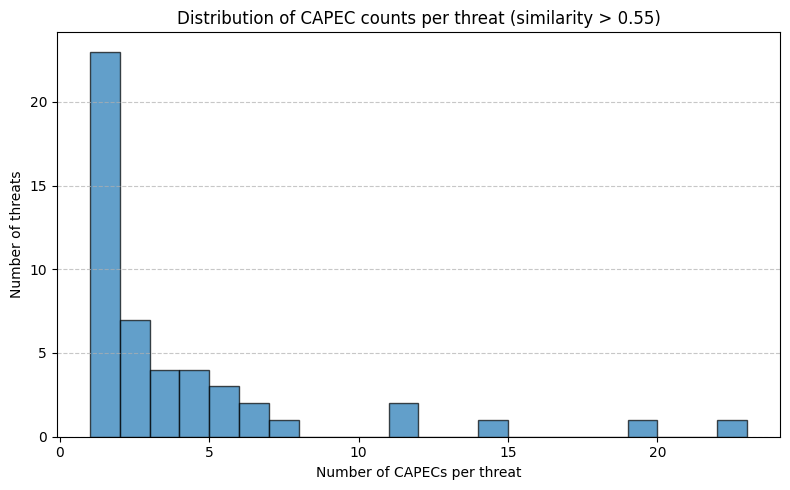

In [118]:
import matplotlib.pyplot as plt

# Filter by similarity
filtered_df = threat2capec_mapping_df[threat2capec_mapping_df["Similarity"] > 0.55]

# Count CAPECs per threat
capec_counts = filtered_df.groupby("Name")["CAPEC ID"].nunique()
print(len(capec_counts))
# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(capec_counts, bins=range(1, capec_counts.max() + 2), edgecolor='black', alpha=0.7)
plt.title("Distribution of CAPEC counts per threat (similarity > 0.55)")
plt.xlabel("Number of CAPECs per threat")
plt.ylabel("Number of threats")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In [139]:
capec_counts[capec_counts >= 14]

Name
T-AppLCM-01     14
T-OPENSRC-02    19
T-rAPP-06       22
Name: CAPEC ID, dtype: int64

In [119]:
filtered_df.Similarity.describe()

count    176.000000
mean       0.576572
std        0.025154
min        0.550044
25%        0.557217
50%        0.569787
75%        0.585756
max        0.660303
Name: Similarity, dtype: float64

In [120]:
threat2capec_mapping_df[threat2capec_mapping_df['Name'] == "T-rAPP-06"]['summary_th_df'].values[0]

'A Threat with the title An attacker bypasses authentication and authorization using an injection attack and the description It is possible that an attacker to submit requests without prior authentication and authorization by executing an injection attack to manipulate configurations, access logs, perform remote code execution, etc.'

In [121]:
capec_counts.describe()

count    49.000000
mean      3.591837
std       4.559415
min       1.000000
25%       1.000000
50%       2.000000
75%       4.000000
max      22.000000
Name: CAPEC ID, dtype: float64

In [123]:
capec_counts.median()

np.float64(2.0)

In [122]:
import numpy as np

In [ ]:
def create_rag_prompt2(threat):
    n_results = 10
    results = get_relevant_informations(threat, collection, n_results=n_results)

    # Prepare CAPEC list with IDs and summaries
    capec_entries = []
    for doc, meta in zip(results['documents'][0], results['metadatas'][0]):
        capec_id = meta.get("CAPEC ID", "N/A")
        capec_entries.append(f"{capec_id}: {doc}")

    capec_information = "\n".join(capec_entries)
    threat_description = threat['summary_th_df']

    # Build the RAG prompt
    prompt = f"""
This task involves mapping a threat summary from the Open Radio Access Network (O-RAN) domain to relevant attack patterns.
O-RAN represents a paradigm shift in Radio Access Network (RAN) design, moving from proprietary hardware to a more open,
virtualized, and software-driven approach. It is used for mobile communication networks, particularly for 5G and future
generations. Key principles of O-RAN include:
- Open System: Characterized by standardized, open interfaces to foster a multi-vendor ecosystem.
- Disaggregated RAN: Functionalities are distributed across different physical or virtual network functions.
- Software-Driven Approach: Components are deployed on white-box appliances and accelerators.
- Closed-Loop Control: Enabled by data-driven components deployed on RAN Intelligent Controllers (RICs).

Now, based on the context above, analyze the following threat summary:
{threat_description}

Additionally, consider the following list of candidate CAPEC entries that were retrieved from a vector database as the 20
most similar attack patterns to the given threat summary:

{capec_information}

From this list, identify which CAPEC IDs are most relevant to the described threat.

As an output, provide only a JSON array containing the selected CAPEC IDs.
Do not include any explanations or additional text, only the JSON array.
"""
    return prompt.strip()


In [127]:
small_models = ['deepseek-r1:1.5b']

In [128]:
rag_test = model_inference_ollama(small_models, test_threat, create_rag_prompt)

100%|██████████| 1/1 [01:14<00:00, 74.44s/it]

Inference for model deepseek-r1:1.5b completed for threat T-A1-02


In [129]:
display_model_results_ollama(small_models, rag_test)

Model: deepseek-r1:1.5b
Speed: 13.18 tokens/second
Total runtime: 00 m 50.08 seconds

Output:


[
  {
    "capec_id": "94"
  }
]

In [130]:
medium_models = ['deepseek-r1:8b']

In [131]:
rag_test_medium = model_inference_ollama(medium_models, test_threat, create_rag_prompt)

100%|██████████| 1/1 [06:42<00:00, 402.17s/it]

Inference for model deepseek-r1:8b completed for threat T-A1-02


In [132]:
display_model_results_ollama(medium_models, rag_test_medium)

Model: deepseek-r1:8b
Speed: 4.44 tokens/second
Total runtime: 02 m 48.55 seconds

Output:


```json
["CAPEC-94", "CAPEC-272"]
```

## Fine Tuning with LoRA

In [9]:
from unsloth import FastLanguageModel, is_bfloat16_supported
from transformers import TrainingArguments
from trl import SFTTrainer
import wandb


/tmp/ipykernel_3837/4019501768.py:1: UserWarning: WARNING: Unsloth should be imported before transformers, peft to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel, is_bfloat16_supported


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [14]:
wnb_token = os.getenv("WNB_TOKEN")

In [ ]:
wandb.login(key=wnb_token)
run = wandb.init(
    project="capec-mapping",
    job_type="training",
    anonymous="allow",
        )
    # config={
    #     "model_name": "deepseek-r1:8b",
    #     "dataset": "mapped_data/lora_training_data.jsonl",
    #     "batch_size": 4,
    #     "learning_rate": 2e-5,
    #     "num_train_epochs": 3,
    #     "gradient_accumulation_steps": 1,
    #     "logging_steps": 10,
    #     "save_steps": 1000,
    # 



SyntaxError: closing parenthesis '}' does not match opening parenthesis '(' on line 2 (651126383.py, line 16)

In [12]:
import json

file_path = 'mapped_data/lora_training_data.jsonl'

# Use a list comprehension to load each line as a separate JSON object
data = [json.loads(line) for line in open(file_path, 'r', encoding='utf-8')]

# 'data' is now a list of dictionaries, one for each line in your file.
pprint(data[0]) # To see the first item

{'capec_id': 'CAPEC-533',
 'mapped_capec': 'A CAPEC with the title Malicious Manual Software Update. The '
                 'description of this CAPEC is:An attacker introduces '
                 "malicious code to the victim's system by altering the "
                 'payload of a software update, allowing for additional '
                 'compromise or site disruption at the victim location. These '
                 'manual, or user-assisted attacks, vary from requiring the '
                 'user to download and run an executable, to as streamlined as '
                 'tricking the user to click a URL. Attacks which aim at '
                 'penetrating a specific network infrastructure often rely '
                 'upon secondary attack methods to achieve the desired impact. '
                 'Spamming, for example, is a common method employed as an '
                 'secondary attack vector. Thus the attacker has in their '
                 'arsenal a choice of initial at

# Evaluation

In [5]:
import re
import json
from datetime import datetime

def run_and_log(func, *args, models, threat_id, environment=None, optimization=None, **kwargs):
    """
    Runs the specified function and logs its runtime, environment,
    optimization info, and timestamp to:
      - a model-suffix-specific evaluation.md file
      - a global evaluation_results.jsonl file
    """

    # Normalize model name and suffix
    model = models[0] if isinstance(models, list) else models

    # Run the function and measure time
    result = func(models=models, *args, **kwargs)
    

    # Access model output
    resp = result[model][0]
    full_output = resp.get("response", "")
    
    # Calculate tokens/sec if available
    tokens_per_second = None
    runtime = None
    if optimization and hasattr(resp, "eval_count") and hasattr(resp, "eval_duration"):
        tokens_per_second = resp.eval_count / (resp.eval_duration / 1e9)
        tokens_per_second = round(tokens_per_second, 2)
        runtime = round(resp.eval_duration / 1e9, 2)
        prompt_token_length = resp.prompt_eval_count
        response_length = resp.eval_count
        timestamp = resp.created_at
        

    # Extract JSON part from output
    json_part = ""
    match_block = re.search(r"```json\s*([\s\S]*?)\s*```", full_output, re.DOTALL)
    # Corrected regex to handle whitespace after the list
    match_list = re.search(r"(\[\s*[\s\S]*?\])\s*$", full_output.strip())
    
    if match_block:
        json_part = match_block.group(1).strip()
    elif match_list:
        json_part = match_list.group(1).strip()
    else:
        json_part = "no json"

    # -------- JSONL logging --------
    log_entry = {
        "Threat_ID": threat_id,
        "Model": model,
        "Optimization": optimization,
        "Prompt_length": prompt_token_length,
        "Response_length": response_length,
        "Model_Speed": tokens_per_second,
        "Runtime": runtime,
        "Json": json_part,
        "Result": full_output,
        "Environment": environment,
        "Timestamp": timestamp,
    }

    jsonl_file = "./results/evaluation_results_v2.jsonl"
    with open(jsonl_file, "a", encoding="utf-8") as f:
        f.write(json.dumps(log_entry, ensure_ascii=False) + "\n")

    return result

In [6]:
models = ['deepseek-r1:1.5b']

In [151]:
models = ['deepseek-r1:14b']

In [176]:
models = ['deepseek-r1:32b']

In [18]:
models = ['deepseek-r1:70b']

In [21]:
models = ['gpt-oss:20b']

In [2]:
import pandas as pd

In [6]:
threat_data_for_PE = pd.read_pickle('threat_data/threat_data_for_PE.pk1')
threat_data_for_PE.columns

Index(['Threat ID', 'summary_th_df'], dtype='object')

In [5]:
threat_data_for_RAG = pd.read_pickle('threat_data/threat_data_for_RAG.pk1')
threat_data_for_RAG.columns

Index(['Threat ID', 'summary_th_df', 'embedding'], dtype='object')

In [41]:
zwi = threat_data_for_RAG[40:]
zwi.head(1)

,Threat ID,summary_th_df,embedding
40,T-rAPP-07,A Threat with the title rApp exploits services and the description A malicious rApp or a trusted but compromised rApp can exploit services across the R1 interface,"[-0.10166528, -0.045797385, -0.029156094, -0.062349226, 0.020032084, -0.015166353, 0.04701072, 0.01796212, -0.0015385542, 0.00723222, -0.013827165, 0.043581787, 0.040378038, -0.031456754, 0.036704104, -0.060887292, 0.06503399, 0.0059152176, 0.03573824, 0.039129473, -0.04448725, -0.025216661, 0.0013282485, -0.03837027, -0.060415737, -0.032347508, -0.037220664, 0.01715333, -0.033138324, -0.045626935, 0.038127128, 0.06605006, -0.042933267, 0.024318958, -0.036561783, 0.025839467, 0.0063423323, 0.019286234, -0.056062162, -0.048145305, 0.037519228, 0.058710504, 0.0047074985, 0.017560188, -0.015958963, -0.06294144, -0.059344098, 0.023443144, -0.020588849, -0.16795005, 0.022537217, -0.038226705, 0.006493976, 0.0007030791, 0.0692236, -0.065255664, 0.027288001, -0.04282686, -0.015141687, -0.012044468, 0.0131647, 0.043700512, -0.034147862, 0.012629333, 0.002178335, 0.0002645286, -0.021035265, 0.056426995, -0.011831759, 0.028883329, -0.06454598, -0.03184044, -0.15354396, -0.020463381, 0.010383298, 0.09285019, 0.035399217, 0.025660282, -0.0048887753, -0.07827097, 0.031825796, 0.063278355, -0.0074412115, 0.040025435, 0.0009511139, 0.08424276, -0.047631454, -0.057499085, 0.065367185, 0.005265329, -0.044320136, -0.022710057, 0.11806606, -0.037001517, 0.10187045, 0.08814606, -0.053028762, -0.18324637, -0.05853317, 0.09545446, ...]"


In [28]:
test = pd.DataFrame(threat_data_for_PE[:52])

In [29]:
test

,Threat ID,summary_th_df
0,T-O-RAN-01,"A Threat with the title An attacker exploits insecure designs or lack of adaption in O-RAN components and the description Unauthenticated/unauthorized access to O-RAN components could possibly be achieved via the different O-RAN interfaces, depending upon the design of the hardware-software O-RAN system and how different functions are segregated within the O-RAN system. \nO-RAN components might be vulnerable if: \n• Outdated component from the lack of update or patch management,\n• Poorly design architecture,\n• Missing appropriate security hardening,\n• Unnecessary or insecure function/protocol/component.\nAn attacker could, in such case, either inject malwares and/or manipulate existing software, harm the O-RAN components, create a performance issue by manipulation of parameters, or reconfigure the O-RAN components and disable the security features with the purpose of eavesdropping or wiretapping on various CUS & M planes, reaching northbound systems, attack broader network to cause denial-of-service, steal unprotected private keys, certificates, hash values, or other type of breaches.\nIn addition, O-RAN components could be software providing network functions, so they are likely to be vulnerable to software flaws: it could be possible to bypass firewall restrictions or to take advantage of a buffer overflow to execute arbitrary commands, etc."
1,T-O-RAN-02,"A Threat with the title An attacker exploits misconfigured or poorly configured O-RAN components and the description Unauthenticated/unauthorized access to O-RAN components could possibly be achieved via the different O-RAN interfaces, depending upon the configuration of the hardware-software O-RAN system. \nO-RAN components might be vulnerable if: \n• Errors from the lack of configuration change management,\n• Misconfigured or poorly configured O-RAN components,\n• Improperly configured permissions,\n• Unnecessary features are enabled (e.g. unnecessary ports, services, accounts, or privileges),\n• Default accounts and their passwords still enabled and unchanged,\n• Security features are disabled or not configured securely.\nAn attacker could, in such case, either inject malwares and/or manipulate existing software, harm the O-RAN components, create a performance issue by manipulation of parameters, or reconfigure the O-RAN components and disable the security features with the purpose of eavesdropping or wiretapping on various CUS & M planes, reaching northbound systems, attack broader network to cause denial-of-service, steal unprotected private keys, certificates, hash values, or other type of breaches."
2,T-O-RAN-03,"A Threat with the title Attacks from the internet to penetrate O-RAN network boundary and the description Web servers serving O-RAN functional and management services should provide adequate protection. \nAn attacker that have access to the uncontrolled O-RAN network could:\n• Bypass the information flow control policy implemented by the firewall,\n• And/or attack O-RAN components in the trusted networks by taking advantage of particularities and errors in the design and implementation of the network protocols (IP, TCP, UDP, application protocols),\n• Use of incorrect or exceeded TCP sequence numbers,\n• Perform brute force attacks on FTP passwords,\n• Use of improper HTTP user sessions,\n• Etc.\nThe effects of such attacks may include:\n• An intrusion, meaning unauthorized access to O-RAN components,\n• Blocking, flooding or restarting an O-RAN component causing a denial of service,\n• Flooding of network equipment, causing a denial of service,\n• Etc."
3,T-O-RAN-04,"A Threat with the title An attacker attempts to jam the airlink signal through IoT devices and the description DDoS attacks on O-RAN systems: The 5G evolution means billions of things, collectively referred to as IoT, will be using the 5G O-RAN. Thus, IoT could increase the risk of O-RAN resource overload by way of DDoS attacks. Attackers create a botn

In [10]:
# Record the start time before the loop
start_time = time.time()

for idx, threat in threat_data_for_PE.iterrows():
    print(f"Threat {idx+1}: {threat['Threat ID']}")
    single_threat_df = pd.DataFrame(threat).T
    
    run_and_log(
        func=model_inference_ollama,
        models=models,
        threat_id=threat['Threat ID'],
        df=single_threat_df,
        prompt_function=create_first_zero_shot_prompt,
        environment="Small",
        optimization='PE-First_ZeroShot'
    )

# Record the end time after the loop
end_time = time.time()

# Calculate the total runtime in seconds
total_runtime_seconds = end_time - start_time

# Create a timedelta object from the total seconds
total_runtime = timedelta(seconds=total_runtime_seconds)

# Print the total runtime
print(f"Total runtime for all threats: {total_runtime} with model {models[0]}")

Threat 1: T-O-RAN-01
model='deepseek-r1:1.5b' created_at='2025-08-30T13:51:39.0343161Z' done=True done_reason='stop' total_duration=31852694300 load_duration=2672434400 prompt_eval_count=307 prompt_eval_duration=3399598800 eval_count=607 eval_duration=25779600500 response='<think>\nOkay, so I need to figure out which CAPEC IDs apply to this threat summary about O-RAN components being vulnerable due to various reasons like outdated software or lack of security measures. Let me start by recalling what each CAPEC ID covers.\n\nFirst, CAPEC 1000 is the highest level, focusing on overall network security and access control. It\'s about preventing unauthorized access and ensuring secure communication. The threat here talks about unauthenticated/unauthorized access to O-RAN components, so that definitely falls under CAPEC 1000 because it\'s about access control.\n\nNext, CAPEC 900 is the second level, which deals with network security and access management. It covers specific vulnerabilities 

In [11]:
# load jsonl content
jsonl_data = pd.read_json("results/evaluation_results_v2.jsonl", lines = True)

In [15]:
jsonl_data['Json'].value_counts().get("no json",0)

np.int64(83)

### Results

In [3]:
our_mappings = pd.read_csv('mapped_data/hfc_general_threats_capec_mapping_min0.55.csv', sep=';')
our_mappings_for_random = our_mappings[['Name', 'summary_th_df']]
random_threats = our_mappings_for_random.drop_duplicates().sample(2, random_state=42)

In [17]:
random_threats

,Name,summary_th_df
17,T-SMO-13,A Threat with the title Malicious actor views local logs and the description Malicious actor accesses locally stored logs in the SMO to perform reconnaissance to collect sensitive or private information.
149,T-OPENSRC-01,"A Threat with the title Developers use SW components with known vulnerabilities and untrusted libraries that can be exploited by an attacker through a backdoor attack and the description The O-RAN Software Community is a Linux Foundation project, supported and funded by O-RAN to lead the implementation of the O-RAN specifications in Open Source. Industry has recognized that Open Source code introduces security risks. Open Source vulnerabilities are publicly available on the National Vulnerability Database (NVD). While this is intended for developers to disclose vulnerabilities, it is also used by hackers to exploit those vulnerabilities. Vulnerabilities frequently propagate as developers re-use free open source code enabling backdoors to attacks. There have been notable vulnerabilities from downloading open source libraries and dependencies, as well as supply chain risks when downloading Open Source code from untrusted repositories.\r\nSome O-RAN vendors and operators may not have accurate inventories of open-source software dependencies used by their different applications, or a process to receive and manage notifications concerning discovered vulnerabilities or available patches from the community supporting the open-source.\r\nSome O-RAN vendors may not have a lack of consistent Supply Chain traceability and security, and a lack of coding best practices conflicts with Security-by-Design principles.\r\nDevelopers may use modules with known vulnerabilities and untrusted libraries that can be exploited by an attacker through a backdoor attack.\r\nAttackers can exploit a vulnerability on the open source code and infects a hypervisor, operating system, VM or container with a malware."


In [4]:
id_1 = random_threats.iloc[0]['Name']
id_2 = random_threats.iloc[1]['Name']

In [19]:
our_mappings[our_mappings['Name'] == id_1]

,Name,Domain,Description,CAPEC ID,Similarity,summary_th_df,summary_ca_df
17,T-SMO-13,enterprise-attack,Malicious actor views local logs,CAPEC-93,0.603871,A Threat with the title Malicious actor views local logs and the description Malicious actor accesses locally stored logs in the SMO to perform reconnaissance to collect sensitive or private information.,"A CAPEC with the title Log Injection-Tampering-Forging. The description of this CAPEC is: This attack targets the log files of the target host. The attacker injects, manipulates or forges malicious log entries in the log file, allowing them to mislead a log audit, cover traces of attack, or perform other malicious actions. The target host is not properly controlling log access. As a result tainted data is resulting in the log files leading to a failure in accountability, non-repudiation and incident forensics capability.. The Domain of this is: Software"
133,T-SMO-13,enterprise-attack,Malicious actor views local logs,CAPEC-268,0.620070,A Threat with the title Malicious actor views local logs and the description Malicious actor accesses locally stored logs in the SMO to perform reconnaissance to collect sensitive or private information.,"A CAPEC with the title Audit Log Manipulation. The description of this CAPEC is: The attacker injects, manipulates, deletes, or forges malicious log entries into the log file, in an attempt to mislead an audit of the log file or cover tracks of an attack. Due to either insufficient access controls of the log files or the logging mechanism, the attacker is able to perform such actions.. The Domain of this is: Software"


In [20]:
our_mappings[our_mappings['Name'] == id_2]

,Name,Domain,Description,CAPEC ID,Similarity,summary_th_df,summary_ca_df
149,T-OPENSRC-01,enterprise-attack,Developers use SW components with known vulnerabilities and untrusted libraries that can be exploited by an attacker through a backdoor attack,CAPEC-538,0.660303,"A Threat with the title Developers use SW components with known vulnerabilities and untrusted libraries that can be exploited by an attacker through a backdoor attack and the description The O-RAN Software Community is a Linux Foundation project, supported and funded by O-RAN to lead the implementation of the O-RAN specifications in Open Source. Industry has recognized that Open Source code introduces security risks. Open Source vulnerabilities are publicly available on the National Vulnerability Database (NVD). While this is intended for developers to disclose vulnerabilities, it is also used by hackers to exploit those vulnerabilities. Vulnerabilities frequently propagate as developers re-use free open source code enabling backdoors to attacks. There have been notable vulnerabilities from downloading open source libraries and dependencies, as well as supply chain risks when downloading Open Source code from untrusted repositories.\r\nSome O-RAN vendors and operators may not have accurate inventories of open-source software dependencies used by their different applications, or a process to receive and manage notifications concerning discovered vulnerabilities or available patches from the community supporting the open-source.\r\nSome O-RAN vendors may not have a lack of consistent Supply Chain traceability and security, and a lack of coding best practices conflicts with Security-by-Design principles.\r\nDevelopers may use modules with known vulnerabilities and untrusted libraries that can be exploited by an attacker through a backdoor attack.\r\nAttackers can exploit a vulnerability on the open source code and infects a hypervisor, operating system, VM or container with a malware.","A CAPEC with the title Open-Source Library Manipulation. The description of this CAPEC is: Adversaries implant malicious code in open source software (OSS) libraries to have it widely distributed, as OSS is commonly downloaded by developers and other users to incorporate into software development projects. The adversary can have a particular system in mind to target, or the implantation can be the first stage of follow-on attacks on many systems.. The Domain of this is: Software"


In [5]:
jsonl_data = pd.read_json("results/evaluation_results_v2.jsonl", lines=True)

In [6]:
# Calculate the total length
jsonl_data['Total_length'] = jsonl_data['Prompt_length'] + jsonl_data['Response_length']

# Find the row with the maximum total length
max_length_row = jsonl_data.loc[jsonl_data['Total_length'].idxmax()]

# Print the resulting row
print(max_length_row)

Threat_ID                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [7]:
# Zählt die Häufigkeit jedes Werts in der Spalte "Model"
model_counts = jsonl_data["Model"].value_counts()

print("Anzahl der Zeilen pro Modellname:")
print(model_counts)


Anzahl der Zeilen pro Modellname:
Model
deepseek-r1:32b     1092
deepseek-r1:14b     1092
deepseek-r1:1.5b    1092
Name: count, dtype: int64


In [8]:
opti_counts = jsonl_data["Optimization"].value_counts()

print("Anzahl der Zeilen pro Optimierungsart:")
print(opti_counts)

Anzahl der Zeilen pro Optimierungsart:
Optimization
RAG                   546
PE-CoT                546
PE-FewShot            546
PE-Third_ZeroShot     546
PE-Second_ZeroShot    546
PE-First_ZeroShot     546
Name: count, dtype: int64


In [9]:
# Gruppiert nach "Model" und dann nach "Optimization" und zählt die Zeilen in jeder Gruppe
model_optimization_counts = jsonl_data.groupby(["Model", "Optimization"]).size().reset_index(name='Count')

print("Anzahl der Zeilen pro Modell und Optimierungsart:")
print(model_optimization_counts)


Anzahl der Zeilen pro Modell und Optimierungsart:
               Model        Optimization  Count
0   deepseek-r1:1.5b              PE-CoT    182
1   deepseek-r1:1.5b          PE-FewShot    182
2   deepseek-r1:1.5b   PE-First_ZeroShot    182
3   deepseek-r1:1.5b  PE-Second_ZeroShot    182
4   deepseek-r1:1.5b   PE-Third_ZeroShot    182
5   deepseek-r1:1.5b                 RAG    182
6    deepseek-r1:14b              PE-CoT    182
7    deepseek-r1:14b          PE-FewShot    182
8    deepseek-r1:14b   PE-First_ZeroShot    182
9    deepseek-r1:14b  PE-Second_ZeroShot    182
10   deepseek-r1:14b   PE-Third_ZeroShot    182
11   deepseek-r1:14b                 RAG    182
12   deepseek-r1:32b              PE-CoT    182
13   deepseek-r1:32b          PE-FewShot    182
14   deepseek-r1:32b   PE-First_ZeroShot    182
15   deepseek-r1:32b  PE-Second_ZeroShot    182
16   deepseek-r1:32b   PE-Third_ZeroShot    182
17   deepseek-r1:32b                 RAG    182


Creating the test data for each model

In [14]:
## First Zero-Shot
optimization = "PE-First_ZeroShot"

## 1.5b
first_random_first_zero_shot_1_5b = jsonl_data[
    (jsonl_data["Model"] == "deepseek-r1:1.5b") &
    (jsonl_data["Optimization"] == optimization) &
    (jsonl_data["Environment"] == "Small") &
    (jsonl_data["Threat_ID"] == id_1)
]
second_random_first_zero_shot_1_5b = jsonl_data[
    (jsonl_data["Model"] == "deepseek-r1:1.5b") &
    (jsonl_data["Optimization"] == optimization) &
    (jsonl_data["Environment"] == "Small") &
    (jsonl_data["Threat_ID"] == id_2)
]

## 14b
first_random_first_zero_shot_14b = jsonl_data[
    (jsonl_data["Model"] == "deepseek-r1:14b") &
    (jsonl_data["Optimization"] == optimization) &
    (jsonl_data["Environment"] == "Medium") &
    (jsonl_data["Threat_ID"] == id_1)
]
second_random_first_zero_shot_14b = jsonl_data[
    (jsonl_data["Model"] == "deepseek-r1:14b") &
    (jsonl_data["Optimization"] == optimization) &
    (jsonl_data["Environment"] == "Medium") &
    (jsonl_data["Threat_ID"] == id_2)
]

## 32b
first_random_first_zero_shot_32b = jsonl_data[
    (jsonl_data["Model"] == "deepseek-r1:32b") &
    (jsonl_data["Optimization"] == optimization) &
    (jsonl_data["Environment"] == "Medium") &
    (jsonl_data["Threat_ID"] == id_1)
]
second_random_first_zero_shot_32b = jsonl_data[
    (jsonl_data["Model"] == "deepseek-r1:32b") &
    (jsonl_data["Optimization"] == optimization) &
    (jsonl_data["Environment"] == "Medium") &
    (jsonl_data["Threat_ID"] == id_2)
]
## Second Zero-Shot
optimization = "PE-Second_ZeroShot"

## 1.5b
first_random_second_zero_shot_1_5b = jsonl_data[
    (jsonl_data["Model"] == "deepseek-r1:1.5b") &
    (jsonl_data["Optimization"] == optimization) &
    (jsonl_data["Environment"] == "Small") &
    (jsonl_data["Threat_ID"] == id_1)
]
second_random_second_zero_shot_1_5b = jsonl_data[
    (jsonl_data["Model"] == "deepseek-r1:1.5b") &
    (jsonl_data["Optimization"] == optimization) &
    (jsonl_data["Environment"] == "Small") &
    (jsonl_data["Threat_ID"] == id_2)
]

## 14b
first_random_second_zero_shot_14b = jsonl_data[
    (jsonl_data["Model"] == "deepseek-r1:14b") &
    (jsonl_data["Optimization"] == optimization) &
    (jsonl_data["Environment"] == "Medium") &
    (jsonl_data["Threat_ID"] == id_1)
]
second_random_second_zero_shot_14b = jsonl_data[
    (jsonl_data["Model"] == "deepseek-r1:14b") &
    (jsonl_data["Optimization"] == optimization) &
    (jsonl_data["Environment"] == "Medium") &
    (jsonl_data["Threat_ID"] == id_2)
]

## 32b
first_random_second_zero_shot_32b = jsonl_data[
    (jsonl_data["Model"] == "deepseek-r1:32b") &
    (jsonl_data["Optimization"] == optimization) &
    (jsonl_data["Environment"] == "Medium") &
    (jsonl_data["Threat_ID"] == id_1)
]
second_random_second_zero_shot_32b = jsonl_data[
    (jsonl_data["Model"] == "deepseek-r1:32b") &
    (jsonl_data["Optimization"] == optimization) &
    (jsonl_data["Environment"] == "Medium") &
    (jsonl_data["Threat_ID"] == id_2)
]
## Third Zero-Shot
optimization = "PE-Third_ZeroShot"

## 1.5b
first_random_third_zero_shot_1_5b = jsonl_data[
    (jsonl_data["Model"] == "deepseek-r1:1.5b") &
    (jsonl_data["Optimization"] == optimization) &
    (jsonl_data["Environment"] == "Small") &
    (jsonl_data["Threat_ID"] == id_1)
]
second_random_third_zero_shot_1_5b = jsonl_data[
    (jsonl_data["Model"] == "deepseek-r1:1.5b") &
    (jsonl_data["Optimization"] == optimization) &
    (jsonl_data["Environment"] == "Small") &
    (jsonl_data["Threat_ID"] == id_2)
]

## 14b
first_random_third_zero_shot_14b = jsonl_data[
    (jsonl_data["Model"] == "deepseek-r1:14b") &
    (jsonl_data["Optimization"] == optimization) &
    (jsonl_data["Environment"] == "Medium") &
    (jsonl_data["Threat_ID"] == id_1)
]
second_random_third_zero_shot_14b = jsonl_data[
    (jsonl_data["Model"] == "deepseek-r1:14b") &
    (jsonl_data["Optimization"] == optimization) &
    (jsonl_data["Environment"] == "Medium") &
    (jsonl_data["Threat_ID"] == id_2)
]

## 32b
first_random_third_zero_shot_32b = jsonl_data[
    (jsonl_data["Model"] == "deepseek-r1:32b") &
    (jsonl_data["Optimization"] == optimization) &
    (jsonl_data["Environment"] == "Medium") &
    (jsonl_data["Threat_ID"] == id_1)
]
second_random_third_zero_shot_32b = jsonl_data[
    (jsonl_data["Model"] == "deepseek-r1:32b") &
    (jsonl_data["Optimization"] == optimization) &
    (jsonl_data["Environment"] == "Medium") &
    (jsonl_data["Threat_ID"] == id_2)
]

## Few-Shot
optimization = "PE-FewShot"
## 1.5b

first_random_few_shot_1_5b = filtered_df = jsonl_data[
    (jsonl_data["Model"] == "deepseek-r1:1.5b") &
    (jsonl_data["Optimization"] == optimization) &
    (jsonl_data["Environment"] == "Small") &
    (jsonl_data["Threat_ID"] == id_1)
]
second_random_few_shot_1_5b = filtered_df = jsonl_data[
    (jsonl_data["Model"] == "deepseek-r1:1.5b") &
    (jsonl_data["Optimization"] == optimization) &
    (jsonl_data["Environment"] == "Small") &
    (jsonl_data["Threat_ID"] == id_2)
]
## 14b
first_random_few_shot_14 = filtered_df = jsonl_data[
    (jsonl_data["Model"] == "deepseek-r1:14b") &
    (jsonl_data["Optimization"] == optimization) &
    (jsonl_data["Environment"] == "Medium") &
    (jsonl_data["Threat_ID"] == id_1)
]
second_random_few_shot_14 = filtered_df = jsonl_data[
    (jsonl_data["Model"] == "deepseek-r1:14b") &
    (jsonl_data["Optimization"] == optimization) &
    (jsonl_data["Environment"] == "Medium") &
    (jsonl_data["Threat_ID"] == id_2)
]
##32b
first_random_few_shot_32 = filtered_df = jsonl_data[
    (jsonl_data["Model"] == "deepseek-r1:32b") &
    (jsonl_data["Optimization"] == optimization) &
    (jsonl_data["Environment"] == "Medium") &
    (jsonl_data["Threat_ID"] == id_1)
]
second_random_few_shot_32 = filtered_df = jsonl_data[
    (jsonl_data["Model"] == "deepseek-r1:32b") &
    (jsonl_data["Optimization"] == optimization) &
    (jsonl_data["Environment"] == "Medium") &
    (jsonl_data["Threat_ID"] == id_2)
]



## Chain of Thought
optimization = "PE-CoT"
##1.5b
first_random_cot_1_5b = filtered_df = jsonl_data[
    (jsonl_data["Model"] == "deepseek-r1:1.5b") &
    (jsonl_data["Optimization"] == optimization) &
    (jsonl_data["Environment"] == "Small") &
    (jsonl_data["Threat_ID"] == id_1)
]
second_random_cot_1_5b = filtered_df = jsonl_data[
    (jsonl_data["Model"] == "deepseek-r1:1.5b") &
    (jsonl_data["Optimization"] == optimization) &
    (jsonl_data["Environment"] == "Small") &
    (jsonl_data["Threat_ID"] == id_2)
]

## 14
first_random_cot_14 = filtered_df = jsonl_data[
    (jsonl_data["Model"] == "deepseek-r1:14b") &
    (jsonl_data["Optimization"] == optimization) &
    (jsonl_data["Environment"] == "Medium") &
    (jsonl_data["Threat_ID"] == id_1)
]
second_random_cot_14 = filtered_df = jsonl_data[
    (jsonl_data["Model"] == "deepseek-r1:14b") &
    (jsonl_data["Optimization"] == optimization) &
    (jsonl_data["Environment"] == "Medium") &
    (jsonl_data["Threat_ID"] == id_2)
]
##32

first_random_cot_32 = filtered_df = jsonl_data[
    (jsonl_data["Model"] == "deepseek-r1:32b") &
    (jsonl_data["Optimization"] == optimization) &
    (jsonl_data["Environment"] == "Medium") &
    (jsonl_data["Threat_ID"] == id_1)
]
second_random_cot_32 = filtered_df = jsonl_data[
    (jsonl_data["Model"] == "deepseek-r1:32b") &
    (jsonl_data["Optimization"] ==  optimization) &
    (jsonl_data["Environment"] == "Medium") &
    (jsonl_data["Threat_ID"] == id_2)
]

## RAG
optimization = "RAG"

## 1.5b
first_random_rag_1_5b = jsonl_data[
    (jsonl_data["Model"] == "deepseek-r1:1.5b") &
    (jsonl_data["Optimization"] == optimization) &
    (jsonl_data["Environment"] == "Small") &
    (jsonl_data["Threat_ID"] == id_1)
]
second_random_rag_1_5b = jsonl_data[
    (jsonl_data["Model"] == "deepseek-r1:1.5b") &
    (jsonl_data["Optimization"] == optimization) &
    (jsonl_data["Environment"] == "Small") &
    (jsonl_data["Threat_ID"] == id_2)
]

## 14b
first_random_rag_14b = jsonl_data[
    (jsonl_data["Model"] == "deepseek-r1:14b") &
    (jsonl_data["Optimization"] == optimization) &
    (jsonl_data["Environment"] == "Medium") &
    (jsonl_data["Threat_ID"] == id_1)
]
second_random_rag_14b = jsonl_data[
    (jsonl_data["Model"] == "deepseek-r1:14b") &
    (jsonl_data["Optimization"] == optimization) &
    (jsonl_data["Environment"] == "Medium") &
    (jsonl_data["Threat_ID"] == id_2)
]

## 32b
first_random_rag_32b = jsonl_data[
    (jsonl_data["Model"] == "deepseek-r1:32b") &
    (jsonl_data["Optimization"] == optimization) &
    (jsonl_data["Environment"] == "Medium") &
    (jsonl_data["Threat_ID"] == id_1)
]
second_random_rag_32b = jsonl_data[
    (jsonl_data["Model"] == "deepseek-r1:32b") &
    (jsonl_data["Optimization"] == optimization) &
    (jsonl_data["Environment"] == "Medium") &
    (jsonl_data["Threat_ID"] == id_2)
]


Prompt Engineering

First Zero-Shot

1.5b

In [18]:
pprint(first_random_first_zero_shot_1_5b['Result'].values[0])
pprint(first_random_first_zero_shot_1_5b['Json'].values[0])

('<think>\n'
 'Okay, so I need to figure out which CAPEC IDs apply to this threat summary. '
 'Let me start by understanding what each CAPEC ID stands for and then see how '
 'they might relate here.\n'
 '\n'
 'First, CAPEC is the Canadian Armed Pacificelta Engagement and Event '
 'Conceptization framework. Each code has specific domains or functions it '
 'covers. The threat described involves a malicious actor accessing locally '
 'stored logs in SMO to perform reconnaissance for sensitive information.\n'
 '\n'
 'Let me break down the threat: Malicious actor views local logs, which means '
 "they have access to these logs. They're doing reconnaissance—so gathering "
 'information—is private or sensitive. So, the key elements are access to logs '
 'and reconnaissance for sensitive info.\n'
 '\n'
 'Now, looking at each CAPEC code:\n'
 '\n'
 '1. **02.05.00** - Accessing internal resources. This seems relevant because '
 'the actor is accessing local logs.\n'
 "2. **03.04.00** - reconnai

In [27]:
(first_random_first_zero_shot_1_5b['Json'].values[0])

'[\n  "02.05.00", // Accessing internal resources (logs)\n  "03.04.00", // Reconnaissance activities (gathering info)\n  "06.07.00", // Accessing sensitive or private information (sensitive info)\n  "15.08.00"  // Strategic use of internal resources (log access for reconnaissance)\n]'

In [28]:
pprint(second_random_first_zero_shot_1_5b['Result'].values[0])
json.loads(second_random_first_zero_shot_1_5b['Json'].values[0])

('<think>\n'
 'Okay, so I need to figure out which CAPEC IDs apply to this threat summary '
 'about vulnerabilities in O-RAN software components. Let me start by '
 'recalling what CAPEC stands for: C (Controlled Environment), A (Awareness), '
 'P (Prevention), E (Exposure), and C (Control). Each of these areas has '
 'specific codes assigned, so I need to identify which ones are relevant '
 'here.\n'
 '\n'
 "Looking at the threat summary, it mentions vulnerabilities in O-RAN's "
 'software components. The key points are that developers use known '
 'vulnerabilities with untrusted libraries, backdoor attacks possible, and '
 "supply chain risks from downloading code from untrusted sources. There's "
 'also mention of hypervisors being infected by malware due to open-source '
 'vulnerabilities.\n'
 '\n'
 "Now, I'll go through each CAPEC area:\n"
 '\n'
 '1. **Controlled Environment (C):** This is about ensuring that systems are '
 'secure within defined boundaries. The threat mentions ex

['C', 'A', 'P', 'E', 'C']

14b

In [29]:
pprint(first_random_first_zero_shot_14b['Result'].values[0])
json.loads(first_random_first_zero_shot_14b['Json'].values[0])

('<think>\n'
 'Okay, so I need to figure out which CAPEC IDs are most relevant to the given '
 'threat. The threat is about a malicious actor accessing locally stored logs '
 'in the SMO (which I think stands for System Management Object or something '
 'similar) to gather sensitive information through reconnaissance.\n'
 '\n'
 'First, I should understand what CAPEC is. From what I remember, CAPEC stands '
 "for Common Attack Pattern Enumeration and Classification. It's a list of "
 'attack patterns that help describe different ways attackers can exploit '
 'systems. Each CAPEC ID corresponds to a specific type of attack or '
 'vulnerability exploitation method.\n'
 '\n'
 'The threat here involves accessing logs stored locally. So the malicious '
 'actor is looking into these logs to gather sensitive data. I need to find '
 'which CAPEC entries fit this scenario.\n'
 '\n'
 "I'll start by thinking about what kind of attacks involve accessing logs. "
 'One possibility is information gath

['CAPEC-107', 'CAPEC-239']

In [30]:
pprint(second_random_first_zero_shot_14b['Result'].values[0])
json.loads(second_random_first_zero_shot_14b['Json'].values[0])

('<think>\n'
 'Okay, so I need to figure out which CAPEC (Common Attack Pattern Enumeration '
 'and Classification) IDs are most relevant to the given threat summary. Let '
 'me start by understanding what the threat is about.\n'
 '\n'
 'The threat describes issues with developers using open-source software '
 'components that have known vulnerabilities and untrusted libraries. These '
 'can be exploited through backdoor attacks. The context mentions O-RAN '
 'Software Community, which uses Open Source code but faces security risks '
 'because of how vulnerabilities are handled or not handled properly by '
 'vendors and operators.\n'
 '\n'
 'So the main points here are:\n'
 '1. Use of open-source components with known vulnerabilities.\n'
 '2. Untrusted libraries that can be exploited via backdoor attacks.\n'
 '3. Lack of proper inventory and management of these dependencies, leading to '
 'supply chain risks.\n'
 '4. Attackers exploiting these vulnerabilities to infect hypervisors, OS,

['CAPEC-107', 'CAPEC-468', 'CAPEC-590']

32b

In [31]:
pprint(first_random_first_zero_shot_32b['Result'].values[0])
json.loads(first_random_first_zero_shot_32b['Json'].values[0])

('<think>\n'
 'Okay, so I need to figure out the most relevant CAPEC IDs for the given '
 'threat summary. The threat is titled "Malicious actor views local logs" and '
 'the description says that the malicious actor accesses locally stored logs '
 'in the SMO (which I think stands for some kind of system or application) to '
 'perform reconnaissance and collect sensitive or private information.\n'
 '\n'
 'First, I should understand what CAPEC IDs are. From what I remember, CAPEC '
 "stands for Common Attack Pattern Enumeration and Classification. It's a list "
 'of attack patterns that describe various ways attackers can exploit systems. '
 'Each CAPEC ID corresponds to a specific type of attack.\n'
 '\n'
 'Now, looking at the threat description: the attacker is accessing local logs '
 'to gather sensitive info. So, this seems like an information gathering or '
 'reconnaissance activity. I need to find which CAPEC entries relate to '
 'accessing logs for such purposes.\n'
 '\n'
 "I'll

['CAPEC-100', 'CAPEC-259']

In [32]:
pprint(second_random_first_zero_shot_32b['Result'].values[0])
json.loads(second_random_first_zero_shot_32b['Json'].values[0])

('<think>\n'
 'Okay, so I need to figure out the most relevant CAPEC IDs for the given '
 'threat summary. Let me start by understanding what the threat is about.\n'
 '\n'
 'The threat talks about developers using software components with known '
 'vulnerabilities and untrusted libraries, which can be exploited through '
 'backdoor attacks. It mentions that open-source code introduces security '
 'risks because vulnerabilities are publicly available on the NVD. Hackers use '
 "these to exploit systems. There's also a mention of supply chain risks when "
 'downloading from untrusted repositories.\n'
 '\n'
 "The threat summary points out that some O-RAN vendors and operators don't "
 'have accurate inventories of their open-source dependencies or processes for '
 "managing vulnerability notifications. Additionally, there's a lack of "
 'consistent supply chain traceability and security, as well as coding best '
 'practices conflicting with Security-by-Design principles. Developers might 

['CAPEC-25', 'CAPEC-396', 'CAPEC-108', 'CAPEC-276', 'CAPEC-133']

RAG

In [19]:
pprint(first_random_rag_32b['Result'].values[0])

('<think>\n'
 'Alright, I need to figure out which CAPEC entries are most relevant to the '
 'given threat summary. The threat is about a malicious actor accessing '
 'locally stored logs in the SMO to perform reconnaissance and collect '
 'sensitive information.\n'
 '\n'
 "First, I'll look at each CAPEC entry provided and see if it relates to log "
 'access or manipulation. \n'
 '\n'
 '1. **CAPEC-268: Audit Log Manipulation** - This involves injecting, '
 "manipulating, deleting, or forging log entries. It's about misleading audits "
 'or covering tracks, which seems relevant because the threat is about '
 'accessing logs for reconnaissance.\n'
 '\n'
 '2. **CAPEC-93: Log Injection-Tampering-Forging** - Similar to 268 but more '
 'general. It targets log files to inject malicious entries, leading to issues '
 'in accountability and forensics. This directly relates to unauthorized '
 'access to logs.\n'
 '\n'
 '3. **CAPEC-81: Web Server Logs Tampering** - Focuses on web server logs '
 '

In [82]:
pprint(first_random_rag_32['Result'].values[0])

('<think>\n'
 'Alright, I need to figure out which CAPEC entries are most relevant to the '
 'given threat summary. The threat is about a malicious actor accessing '
 'locally stored logs in the SMO to perform reconnaissance and collect '
 'sensitive information.\n'
 '\n'
 "First, I'll look at each CAPEC entry provided and see if it relates to log "
 'access or manipulation. \n'
 '\n'
 '1. **CAPEC-268: Audit Log Manipulation** - This involves injecting, '
 "manipulating, deleting, or forging log entries. It's about misleading audits "
 'or covering tracks, which seems relevant because the threat is about '
 'accessing logs for reconnaissance.\n'
 '\n'
 '2. **CAPEC-93: Log Injection-Tampering-Forging** - Similar to 268 but more '
 'general. It targets log files to inject malicious entries, leading to issues '
 'in accountability and forensics. This directly relates to unauthorized '
 'access to logs.\n'
 '\n'
 '3. **CAPEC-81: Web Server Logs Tampering** - Focuses on web server logs '
 '

In [84]:
pprint(second_random_rag_32['Result'].values[0])

('<think>\n'
 'Alright, I need to figure out which CAPEC entries are most relevant to the '
 'given threat summary about O-RAN. The threat involves developers using '
 'software components with known vulnerabilities and untrusted libraries that '
 'can be exploited through backdoor attacks.\n'
 '\n'
 "First, I'll read through each CAPEC description carefully to see how they "
 'relate to the threat.\n'
 '\n'
 '1. **CAPEC-538: Open-Source Library Manipulation** - This seems directly '
 'relevant because it involves adversaries implanting malicious code in '
 'open-source libraries, which is exactly what the threat describes about '
 'developers using vulnerable or untrusted libraries.\n'
 '\n'
 '2. **CAPEC-691: Spoof Open-Source Software Metadata** - This is also '
 'relevant as it deals with spoofing metadata to make malicious software '
 'appear trustworthy, which ties into the supply chain risks mentioned in the '
 'threat.\n'
 '\n'
 '3. **CAPEC-88: OS Command Injection** - While thi

In [45]:
# Assuming the DataFrame is named threat_data_for_RAG
max_length_row = threat_data_for_RAG.loc[threat_data_for_RAG['summary_th_df'].str.len().idxmax()]

print("The row with the maximum string length is:")
print(max_length_row)

The row with the maximum string length is:
Threat ID                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

### Testing Ollama

In [60]:
def ask_ollama(prompt: str, model: str = "deepseek-r1:8b") -> str:
    """
    Sends a prompt to the Ollama generate endpoint and returns the model's response.
    
    Args:
        prompt (str): The text prompt to send to the model.
        model (str): The model to use
        
    Returns:
        str: The generated text from the model.
    """
    response = ollama.generate(
        model=model,
        prompt=prompt,
        options={
            "seed": 42,
            "temperature": 0,
            "num_ctx": 8192,
            'num_predict': 3000
        }
    )
    return response

In [61]:
prompt = """This task involves mapping a threat summary from the
Open Radio Access Network (O-RAN) domain to relevant attack patterns.
O-RAN represents a paradigm shift in Radio Access Network (RAN)
design, moving from proprietary hardware to a more open,
virtualized, and software-driven approach. It is used for
mobile communication networks, particularly for 5G and future
generations. Key principles of O-RAN include:
- Open System: Characterized by standardized, open
interfaces to foster a multi-vendor ecosystem.
- Disaggregated RAN: Functionalities are distributed
across different physical or virtual network functions.
- Software-Driven Approach: Components are deployed on
white-box appliances and accelerators.
- Closed-Loop Control: Enabled by data-driven components
deployed on RAN Intelligent Controllers (RICs).
Now, based on the context above, analyze the following
threat summary:
A Threat with the title An attacker stands up a false base station attack by attacking an O-RU and the description A false base station attack occurs when an attacker masquerades as a legitimate mobile network to facilitate a Man-in-The-Middle (MiTM) attack between a subscriber’s user equipment (UE) and the mobile network. 
There are three attack scenarios on an O-RU that enable an attacker to realize a false base station attack: 
1. Hijack fronthaul to realize a false base station attack: Attacker disables an operational O-RU’s access to the open fronthaul, plugs a false base station system into the operational O-RU’s fronthaul interface, and launches a false base station attack with the O-RU providing the air interface.
2. Recruit a standalone O-RU to realize a false base station attack: The stand-alone O-RU is an O-RU that is not operational but is available to an attacker to incorporate into a false base station system. The attacker plugs a false base station system into the standalone O-RU’s fronthaul interface and launches a false base station attack with the O-RU providing the air interface.
3. Gain unauthorized physical access to O-RU to realize a false base station attack: An attacker gains access to external and internal components of an O-RU (other than the open fronthaul interface), connects the O-RU under attack to a false base station system, and launches a false base station attack with the O-RU providing the air interface.
Successful attacks may cause:
a) For a subscriber’s UE in attack scenarios 1, 2, and 3: the false base stations, also known as SUPI/5G-GUTI catchers, retrieves a subscriber identity by forcing a UE to attach to the false base station systems. This opens the door to subscriber identity interception/disclosure and unauthorized subscriber tracking attacks. These attacks include stealing subscriber information, tampering with transmitted information, tracking subscribers, and compromising subscriber privacy.
b) For the operator network: in attack scenario 1, the attacker removes the operational O-RU from providing service to UEs in the coverage area served by the operational O-RU.
c) For operators and vendors in attack scenarios 1, 2, and 3, the attacker recruits legitimate operator/vendor equipment for the purpose of creating a false base station attack on subscribers, possibly harming the reputation of the operator and vendor whose O-RU was used in the attack.
NOTE: The false base station threat has existed since GSM networks and continued to evolve and persist with the evolution of mobile networks. 5G networks are expected to introduce several security enhancements over 4G and legacy networks. Despite these security enhancements, 5G networks could still be a target of false base station attacks [19].
Additionally, consider all the following candidate
CAPEC (CAPEC stands for Common Attack Pattern Enumeration and Classification) entries that were retrieved from a vector database as the 23
most similar attack patterns to the given threat summary:
CAPEC Information for CAPEC ID CAPEC-617: A CAPEC with the title Cellular Rogue Base Station. The description of this CAPEC is: In this attack scenario, the attacker imitates a cellular base station with their own "rogue" base station equipment. Since cellular devices connect to whatever station has the strongest signal, the attacker can easily convince a targeted cellular device (e.g. the retransmission device) to talk to the rogue base station.. The Domains of this are: Communications, Hardware
----------------------------------------
CAPEC Information for CAPEC ID CAPEC-605: A CAPEC with the title Cellular Jamming. The description of this CAPEC is: In this attack scenario, the attacker actively transmits signals to overpower and disrupt the communication between a cellular user device and a cell tower. Several existing techniques are known in the open literature for this attack for 2G, 3G, and 4G LTE cellular technology. For example, some attacks target cell towers by overwhelming them with false status messages, while others introduce high levels of noise on signaling channels.. The Domain of this is: Communications
----------------------------------------
CAPEC Information for CAPEC ID CAPEC-466: A CAPEC with the title Leveraging Active Adversary in the Middle Attacks to Bypass Same Origin Policy. The description of this CAPEC is: An attacker leverages an adversary in the middle attack (CAPEC-94) in order to bypass the same origin policy protection in the victim's browser. This active adversary in the middle attack could be launched, for instance, when the victim is connected to a public WIFI hot spot. An attacker is able to intercept requests and responses between the victim's browser and some non-sensitive website that does not use TLS.. The Domains of this are: Communications, Software
----------------------------------------
CAPEC Information for CAPEC ID CAPEC-604: A CAPEC with the title Wi-Fi Jamming. The description of this CAPEC is: In this attack scenario, the attacker actively transmits on the Wi-Fi channel to prevent users from transmitting or receiving data from the targeted Wi-Fi network. There are several known techniques to perform this attack – for example: the attacker may flood the Wi-Fi access point (e.g. the retransmission device) with deauthentication frames. Another method is to transmit high levels of noise on the RF band used by the Wi-Fi network.. The Domain of this is: Communications
----------------------------------------
CAPEC Information for CAPEC ID CAPEC-697: A CAPEC with the title DHCP Spoofing. The description of this CAPEC is: 
            <xhtml:p>An adversary masquerades as a legitimate Dynamic Host Configuration Protocol (DHCP) server by spoofing DHCP traffic, with the goal of redirecting network traffic or denying service to DHCP.</xhtml:p>
         . The Domains of this are: Social Engineering, Software, Hardware
----------------------------------------
CAPEC Information for CAPEC ID CAPEC-615: A CAPEC with the title Evil Twin Wi-Fi Attack. The description of this CAPEC is: Adversaries install Wi-Fi equipment that acts as a legitimate Wi-Fi network access point. When a device connects to this access point, Wi-Fi data traffic is intercepted, captured, and analyzed. This also allows the adversary to use "adversary-in-the-middle" (CAPEC-94) for all communications.. The Domains of this are: Communications, Software, Hardware
----------------------------------------
CAPEC Information for CAPEC ID CAPEC-272: A CAPEC with the title Protocol Manipulation. The description of this CAPEC is: An adversary subverts a communications protocol to perform an attack. This type of attack can allow an adversary to impersonate others, discover sensitive information, control the outcome of a session, or perform other attacks. This type of attack targets invalid assumptions that may be inherent in implementers of the protocol, incorrect implementations of the protocol, or vulnerabilities in the protocol itself.. The Domains of this are: Communications, Software
----------------------------------------
CAPEC Information for CAPEC ID CAPEC-618: A CAPEC with the title Cellular Broadcast Message Request. The description of this CAPEC is: In this attack scenario, the attacker uses knowledge of the target’s mobile phone number (i.e., the number associated with the SIM used in the retransmission device) to cause the cellular network to send broadcast messages to alert the mobile device. Since the network knows which cell tower the target’s mobile device is attached to, the broadcast messages are only sent in the Location Area Code (LAC) where the target is currently located. By triggering the cellular broadcast message and then listening for the presence or absence of that message, an attacker could verify that the target is in (or not in) a given location.. The Domains of this are: Communications, Software
----------------------------------------
CAPEC Information for CAPEC ID CAPEC-90: A CAPEC with the title Reflection Attack in Authentication Protocol. The description of this CAPEC is: An adversary can abuse an authentication protocol susceptible to reflection attack in order to defeat it. Doing so allows the adversary illegitimate access to the target system, without possessing the requisite credentials. Reflection attacks are of great concern to authentication protocols that rely on a challenge-handshake or similar mechanism. An adversary can impersonate a legitimate user and can gain illegitimate access to the system by successfully mounting a reflection attack during authentication.. The Domain of this is: Communications
----------------------------------------
CAPEC Information for CAPEC ID CAPEC-622: A CAPEC with the title Electromagnetic Side-Channel Attack. The description of this CAPEC is: In this attack scenario, the attacker passively monitors electromagnetic emanations that are produced by the targeted electronic device as an unintentional side-effect of its processing. From these emanations, the attacker derives information about the data that is being processed (e.g. the attacker can recover cryptographic keys by monitoring emanations associated with cryptographic processing). This style of attack requires proximal access to the device, however attacks have been demonstrated at public conferences that work at distances of up to 10-15 feet. There have not been any significant studies to determine the maximum practical distance for such attacks. Since the attack is passive, it is nearly impossible to detect and the targeted device will continue to operate as normal after a successful attack.. The Domains of this are: Software, Physical Security, Hardware
----------------------------------------
CAPEC Information for CAPEC ID CAPEC-601: A CAPEC with the title Jamming. The description of this CAPEC is: An adversary uses radio noise or signals in an attempt to disrupt communications. By intentionally overwhelming system resources with illegitimate traffic, service is denied to the legitimate traffic of authorized users.. The Domain of this is: Communications
----------------------------------------
CAPEC Information for CAPEC ID CAPEC-594: A CAPEC with the title Traffic Injection. The description of this CAPEC is: An adversary injects traffic into the target's network connection. The adversary is therefore able to degrade or disrupt the connection, and potentially modify the content. This is not a flooding attack, as the adversary is not focusing on exhausting resources. Instead, the adversary is crafting a specific input to affect the system in a particular way.. The Domains of this are: Communications, Software
----------------------------------------
CAPEC Information for CAPEC ID CAPEC-582: A CAPEC with the title Route Disabling. The description of this CAPEC is: An adversary disables the network route between two targets. The goal is to completely sever the communications channel between two entities. This is often the result of a major error or the use of an "Internet kill switch" by those in control of critical infrastructure. This attack pattern differs from most other obstruction patterns by targeting the route itself, as opposed to the data passed over the route.. The Domains of this are: Social Engineering, Communications, Software, Hardware
----------------------------------------
CAPEC Information for CAPEC ID CAPEC-114: A CAPEC with the title Authentication Abuse. The description of this CAPEC is: An attacker obtains unauthorized access to an application, service or device either through knowledge of the inherent weaknesses of an authentication mechanism, or by exploiting a flaw in the authentication scheme's implementation. In such an attack an authentication mechanism is functioning but a carefully controlled sequence of events causes the mechanism to grant access to the attacker.. The Domains of this are: Software, Hardware
----------------------------------------
CAPEC Information for CAPEC ID CAPEC-559: A CAPEC with the title Orbital Jamming. The description of this CAPEC is: In this attack pattern, the adversary sends disruptive signals at a target satellite using a rogue uplink station to disrupt the intended transmission. Those within the satellite's footprint are prevented from reaching the satellite's targeted or neighboring channels. The satellite's footprint size depends upon its position in the sky; higher orbital satellites cover multiple continents.. The Domain of this is: Communications
----------------------------------------
CAPEC Information for CAPEC ID CAPEC-161: A CAPEC with the title Infrastructure Manipulation. The description of this CAPEC is: An attacker exploits characteristics of the infrastructure of a network entity in order to perpetrate attacks or information gathering on network objects or effect a change in the ordinary information flow between network objects. Most often, this involves manipulation of the routing of network messages so, instead of arriving at their proper destination, they are directed towards an entity of the attackers' choosing, usually a server controlled by the attacker. The victim is often unaware that their messages are not being processed correctly. For example, a targeted client may believe they are connecting to their own bank but, in fact, be connecting to a Pharming site controlled by the attacker which then collects the user's login information in order to hijack the actual bank account.. The Domains of this are: Communications, Software, Hardware
----------------------------------------
CAPEC Information for CAPEC ID CAPEC-628: A CAPEC with the title Carry-Off GPS Attack. The description of this CAPEC is: A common form of a GPS spoofing attack, commonly termed a carry-off attack begins with an adversary broadcasting signals synchronized with the genuine signals observed by the target receiver. The power of the counterfeit signals is then gradually increased and drawn away from the genuine signals. Over time, the adversary can carry the target away from their intended destination and toward a location chosen by the adversary.. The Domain of this is: Communications
----------------------------------------
CAPEC Information for CAPEC ID CAPEC-154: A CAPEC with the title Resource Location Spoofing. The description of this CAPEC is: An adversary deceives an application or user and convinces them to request a resource from an unintended location. By spoofing the location, the adversary can cause an alternate resource to be used, often one that the adversary controls and can be used to help them achieve their malicious goals.. The Domains of this are: Social Engineering, Supply Chain, Communications, Software, Hardware
----------------------------------------
CAPEC Information for CAPEC ID CAPEC-593: A CAPEC with the title Session Hijacking. The description of this CAPEC is: This type of attack involves an adversary that exploits weaknesses in an application's use of sessions in performing authentication. The adversary is able to steal or manipulate an active session and use it to gain unathorized access to the application.. The Domain of this is: Software
----------------------------------------
CAPEC Information for CAPEC ID CAPEC-157: A CAPEC with the title Sniffing Attacks. The description of this CAPEC is: In this attack pattern, the adversary intercepts information transmitted between two third parties. The adversary must be able to observe, read, and/or hear the communication traffic, but not necessarily block the communication or change its content. Any transmission medium can theoretically be sniffed if the adversary can examine the contents between the sender and recipient. Sniffing Attacks are similar to Adversary-In-The-Middle attacks (CAPEC-94), but are entirely passive. AiTM attacks are predominantly active and often alter the content of the communications themselves.. The Domains of this are: Communications, Software
----------------------------------------
CAPEC Information for CAPEC ID CAPEC-173: A CAPEC with the title Action Spoofing. The description of this CAPEC is: An adversary is able to disguise one action for another and therefore trick a user into initiating one type of action when they intend to initiate a different action. For example, a user might be led to believe that clicking a button will submit a query, but in fact it downloads software. Adversaries may perform this attack through social means, such as by simply convincing a victim to perform the action or relying on a user's natural inclination to do so, or through technical means, such as a clickjacking attack where a user sees one interface but is actually interacting with a second, invisible, interface.. The Domains of this are: Social Engineering, Software
----------------------------------------
CAPEC Information for CAPEC ID CAPEC-606: A CAPEC with the title Weakening of Cellular Encryption. The description of this CAPEC is: An attacker, with control of a Cellular Rogue Base Station or through cooperation with a Malicious Mobile Network Operator can force the mobile device (e.g., the retransmission device) to use no encryption (A5/0 mode) or to use easily breakable encryption (A5/1 or A5/2 mode).. The Domain of this is: Software
----------------------------------------
CAPEC Information for CAPEC ID CAPEC-487: A CAPEC with the title ICMP Flood. The description of this CAPEC is: An adversary may execute a flooding attack using the ICMP protocol with the intent to deny legitimate users access to a service by consuming the available network bandwidth. A typical attack involves a victim server receiving ICMP packets at a high rate from a wide range of source addresses. Additionally, due to the session-less nature of the ICMP protocol, the source of a packet is easily spoofed making it difficult to find the source of the attack.. The Domains of this are: Communications, Software
----------------------------------------

From this list, identify which CAPEC IDs are most relevant
to the described threat.
As an output, provide only a JSON array containing the
selected CAPEC IDs.
Do not include any explanations or additional text,
only the JSON array."""

In [64]:
pprint(ask_ollama(prompt=prompt))

GenerateResponse(model='deepseek-r1:8b', created_at='2025-08-27T11:59:21.688905872Z', done=True, done_reason='stop', total_duration=32783094453, load_duration=173203590, prompt_eval_count=3769, prompt_eval_duration=48659676, eval_count=2470, eval_duration=32559596345, response='<think>\nOkay, let\'s tackle this problem step by step. The user provided a detailed threat summary about false base station attacks in O-RAN networks and listed 23 candidate CAPEC entries. They want me to identify which of these are most relevant.\n\nFirst, I need to understand what exactly the false base station attack entails. From the description, it\'s clear that an attacker impersonates a legitimate base station (O-RU) to intercept communications between UEs and the mobile network. The threat summary mentions three scenarios: hijacking fronthaul, using a standalone O-RU, or physical access.\n\nLooking at the CAPEC list, I should focus on attacks related to cellular base stations, protocol manipulation, int